# pyheatmy Demo Notebook for an homogeneous layer

This notebook aims to present the various features of `pyheatmy`. It explains how to:
- create a `Column` object from an easy reading of dates
- execute the direct model, for homogeneous (section 2)  and heterogeneous (section 3) riverbeds
- execute the MCMC
- retrieve and display the various results produced during the executions of the direct model or the MCMC

This notebook doesn't provide yet information on the DREAM method implemented in 2023. For that purpose please refer to the `DREAM_VX.ipynb` notebooks

`pyheatmy` is built around the monolithic `Column` class in `core.py`. It can be executed from this class. Calculation, data retrieval, and plotting are methods provided by the `Column` class.

It is based on real data, which can be found in the `data` folder.

We recommend reading the API for more details. 

In [46]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


from pyheatmy.core import Column
from pyheatmy.layers import Layer, getListParameters
from pyheatmy.params import Param, Prior
from pyheatmy.config import RHO_W, G, DEFAULT_MU, EPSILON, ZERO_CELSIUS

import os
from pathlib import Path
NBCHAINS = 10
DELTA = 4
NCR = 3
NBITERMCMC = 35
NBBURNING = 20
DEBUGRUB = 2. # Gelman Rubin criteria
NBCELLS = 40
NB_TIMESTEPS = 200  # Utilisons un peu plus de points
TIMESTEP_MINUTES = 15  # 15 min
START_DATE = datetime(2025, 10, 1)
NOISE_LEVEL = 0.05  # Niveau de bruit à ajouter aux mesures (en Kelvin)
RIVER_BED_DEPTH = 2.0
DEPTH_SENSORS_ET_FOND = [0.5, 1.0, 1.5, RIVER_BED_DEPTH]  # 3 capteurs + fond
OFFSET = 0.0

## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [47]:
capteur_riviere = pd.read_csv("./data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("./data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("./configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [48]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [49]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

print(f"dH : {dH_measures}")
print(f"Tshaft : {T_measures}")


dH : [(Timestamp('2016-06-28 06:45:00'), (0.8455651738980304, 287.16499999999996)), (Timestamp('2016-06-28 07:00:00'), (0.845598722046913, 287.159)), (Timestamp('2016-06-28 07:15:00'), (0.84563866885015, 287.15799999999996)), (Timestamp('2016-06-28 07:30:00'), (0.8456745294855709, 287.15599999999995)), (Timestamp('2016-06-28 07:45:00'), (0.8457087531923185, 287.15599999999995)), (Timestamp('2016-06-28 08:00:00'), (0.8457346869561947, 287.15599999999995)), (Timestamp('2016-06-28 08:15:00'), (0.8457538391584245, 287.161)), (Timestamp('2016-06-28 08:30:00'), (0.8457628039753982, 287.167)), (Timestamp('2016-06-28 08:45:00'), (0.8457635267129118, 287.174)), (Timestamp('2016-06-28 09:00:00'), (0.8457572935292086, 287.179)), (Timestamp('2016-06-28 09:15:00'), (0.8457517700915217, 287.185)), (Timestamp('2016-06-28 09:30:00'), (0.8457492408521055, 287.19399999999996)), (Timestamp('2016-06-28 09:45:00'), (0.8457605113179875, 287.21799999999996)), (Timestamp('2016-06-28 10:00:00'), (0.84577645940

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [50]:
Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange',
    "nb_cells": NBCELLS,
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

## 2. Colonne homogène

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Modèle direct

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [51]:
Layer_homogenous = {
    "name": "Layer_homogenous",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": .1,
    "lambda_s": 2,
    "rhos_cs": 4e6,
    "q": 1e-5
}

Layer_homogenous = Layer.from_dict(Layer_homogenous)

col.set_layers(Layer_homogenous)


Puis on appelle le modèle direct :

In [52]:
col.compute_solve_transi(verbose=True)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 12, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0, q = 1e-05
Solving the flow with intrinsec permeability 1e-12, and permeability 9.810000000000001e-06
Done.


Et on utilise les méthodes de récupération des résultats et de tracer

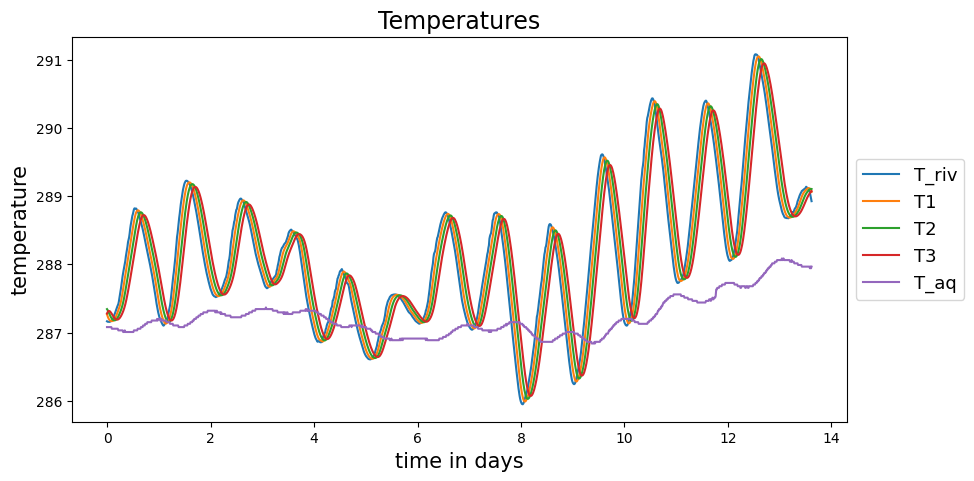

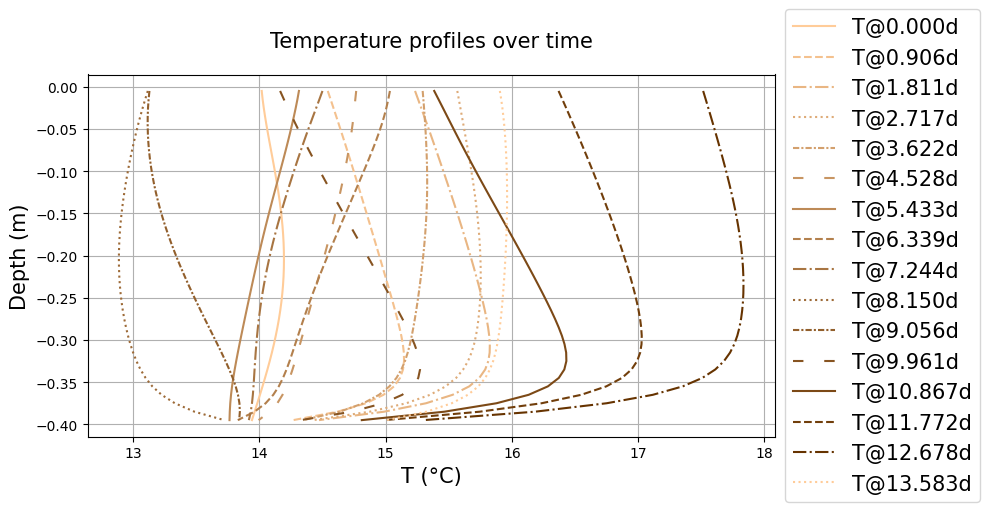

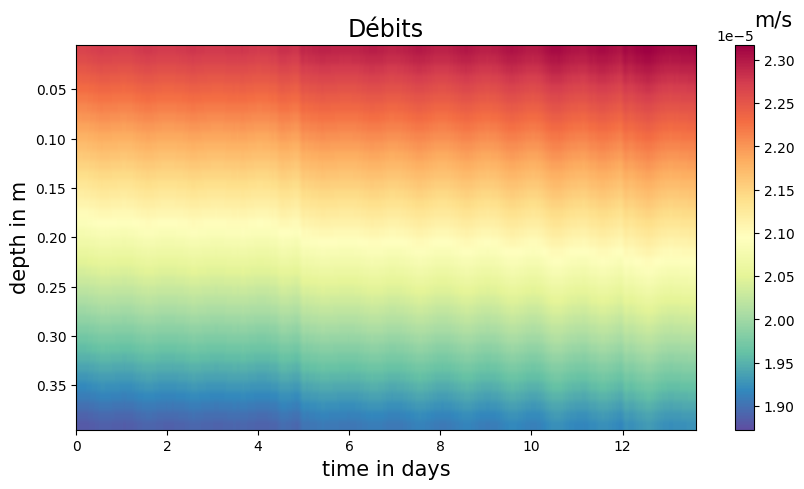

In [53]:
col.plot_temperature_at_sensors()

nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))

flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

Calcul des écarts de température et comparaison des températures simulées et observées

RMSE at sensor 0 : 0.447693911250542
RMSE at sensor 1 : 0.7793790762470973
RMSE at sensor 2 : 0.9533394633674648
Total RMSE : 0.7564649617522177


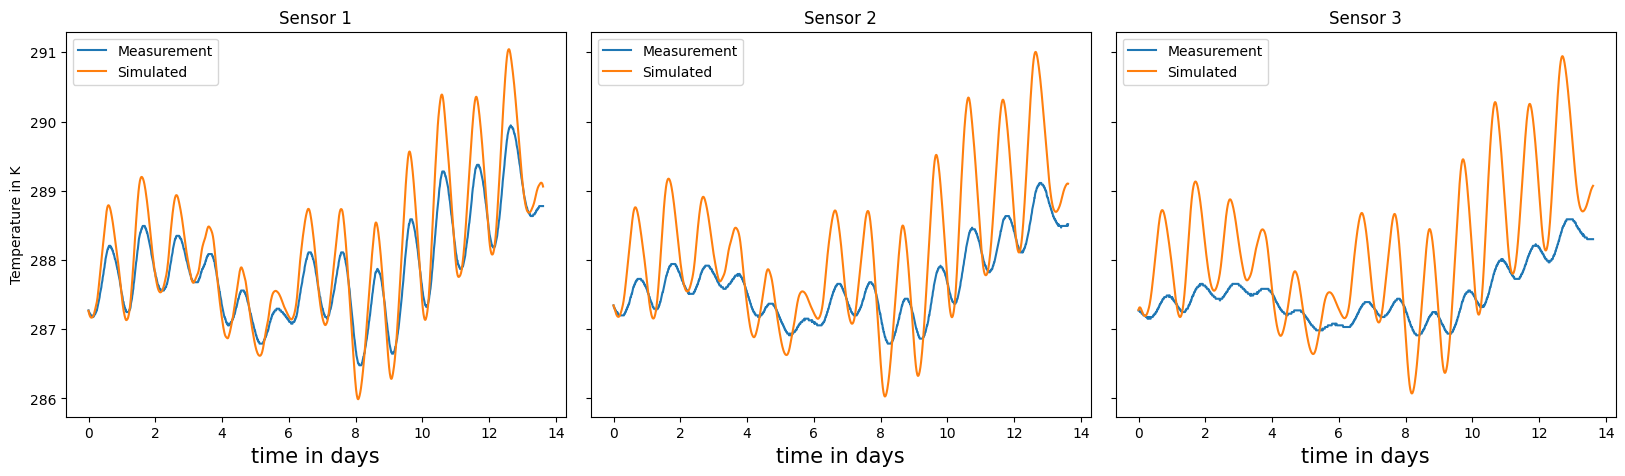

In [54]:
col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()

The simulations are of very pour quality. Let's inverse the data with mcmc

### 2.2 Bayesian inversion

In [55]:
priors = {
    "Prior_moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "Prior_n": ((.01, .25), .01),
    "Prior_lambda_s": ((1, 10), .1),
    "Prior_rhos_cs": ((1e6,1e7), 1e5),
    "Prior_q": ((1e-12, 1e-4), 1e-10),
}

Layer_homogenous.set_priors_from_dict(priors)
print(Layer_homogenous.Prior_list)

[Prior sur une valeure qui évolue entre 11 et 16 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 0.01 et 0.25 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 1 et 10 avec un écart type de 0.1, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0 avec un écart type de 100000.0, Prior sur une valeure qui évolue entre 1e-12 et 0.0001 avec un écart type de 1e-10]


In [56]:
nb_chains=NBCHAINS

col.compute_mcmc(
    nb_iter = NBITERMCMC,
    verbose=True,
    nb_chain = nb_chains,
    nitmaxburning=NBBURNING,
)

--- Compute MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 0.01 et 0.25 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 1 et 10 avec un écart type de 0.1, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0 avec un écart type de 100000.0, Prior sur une valeure qui évolue entre 1e-12 et 0.0001 avec un écart type de 1e-10]
Number of cells : 40
Number of iterations : 35
Number of chains : 10
--------------------
Subsampling for Quantile computation every 1 iterations
Size of the subsampling per chain : 35 iterations among 35 iterations
Initialisation - Utilisation de la mémoire (en Mo) : 242.466816
--- Begin Burn in phase ---


Burn in phase: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 203.07968
DREAM MCMC Computation: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]
Acceptance rate : [0.14285715 0.2        0.14285715 0.22857143 0.22857143 0.2
 0.2        0.08571429 0.2        0.2       ]
Quantiles computed


In [57]:
# On met à jour les paramètres de la colonne avec les paramètres qui minimisent l'erreur après la MCMC
col.get_best_layers()

RMSE at sensor 0 : 0.053701137228347066
RMSE at sensor 1 : 0.07316753412308816
RMSE at sensor 2 : 0.0468598967692571
Total RMSE : 0.05897216890052591


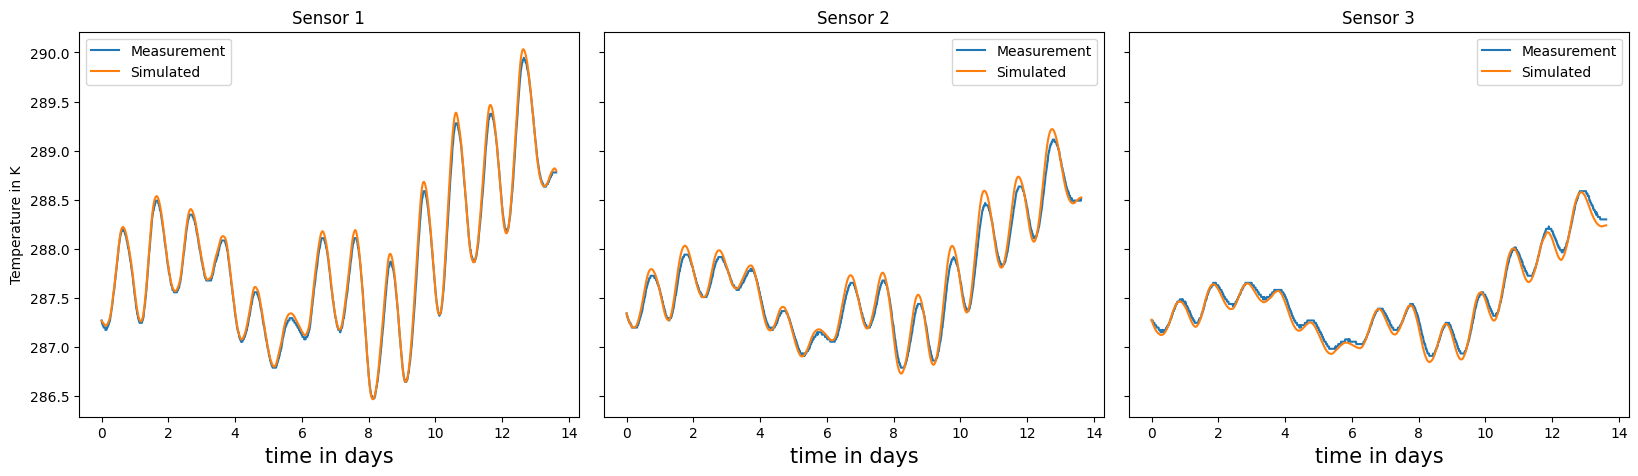

In [58]:
col.compute_solve_transi(verbose=False)
col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()

We see that the simulation is way closer to the measurements

acceptance : 0.0057142856530845165
RMSE at sensor 0 : 0.053701137228347066
RMSE at sensor 1 : 0.07316753412308816
RMSE at sensor 2 : 0.0468598967692571
Total RMSE : 0.05897216890052591


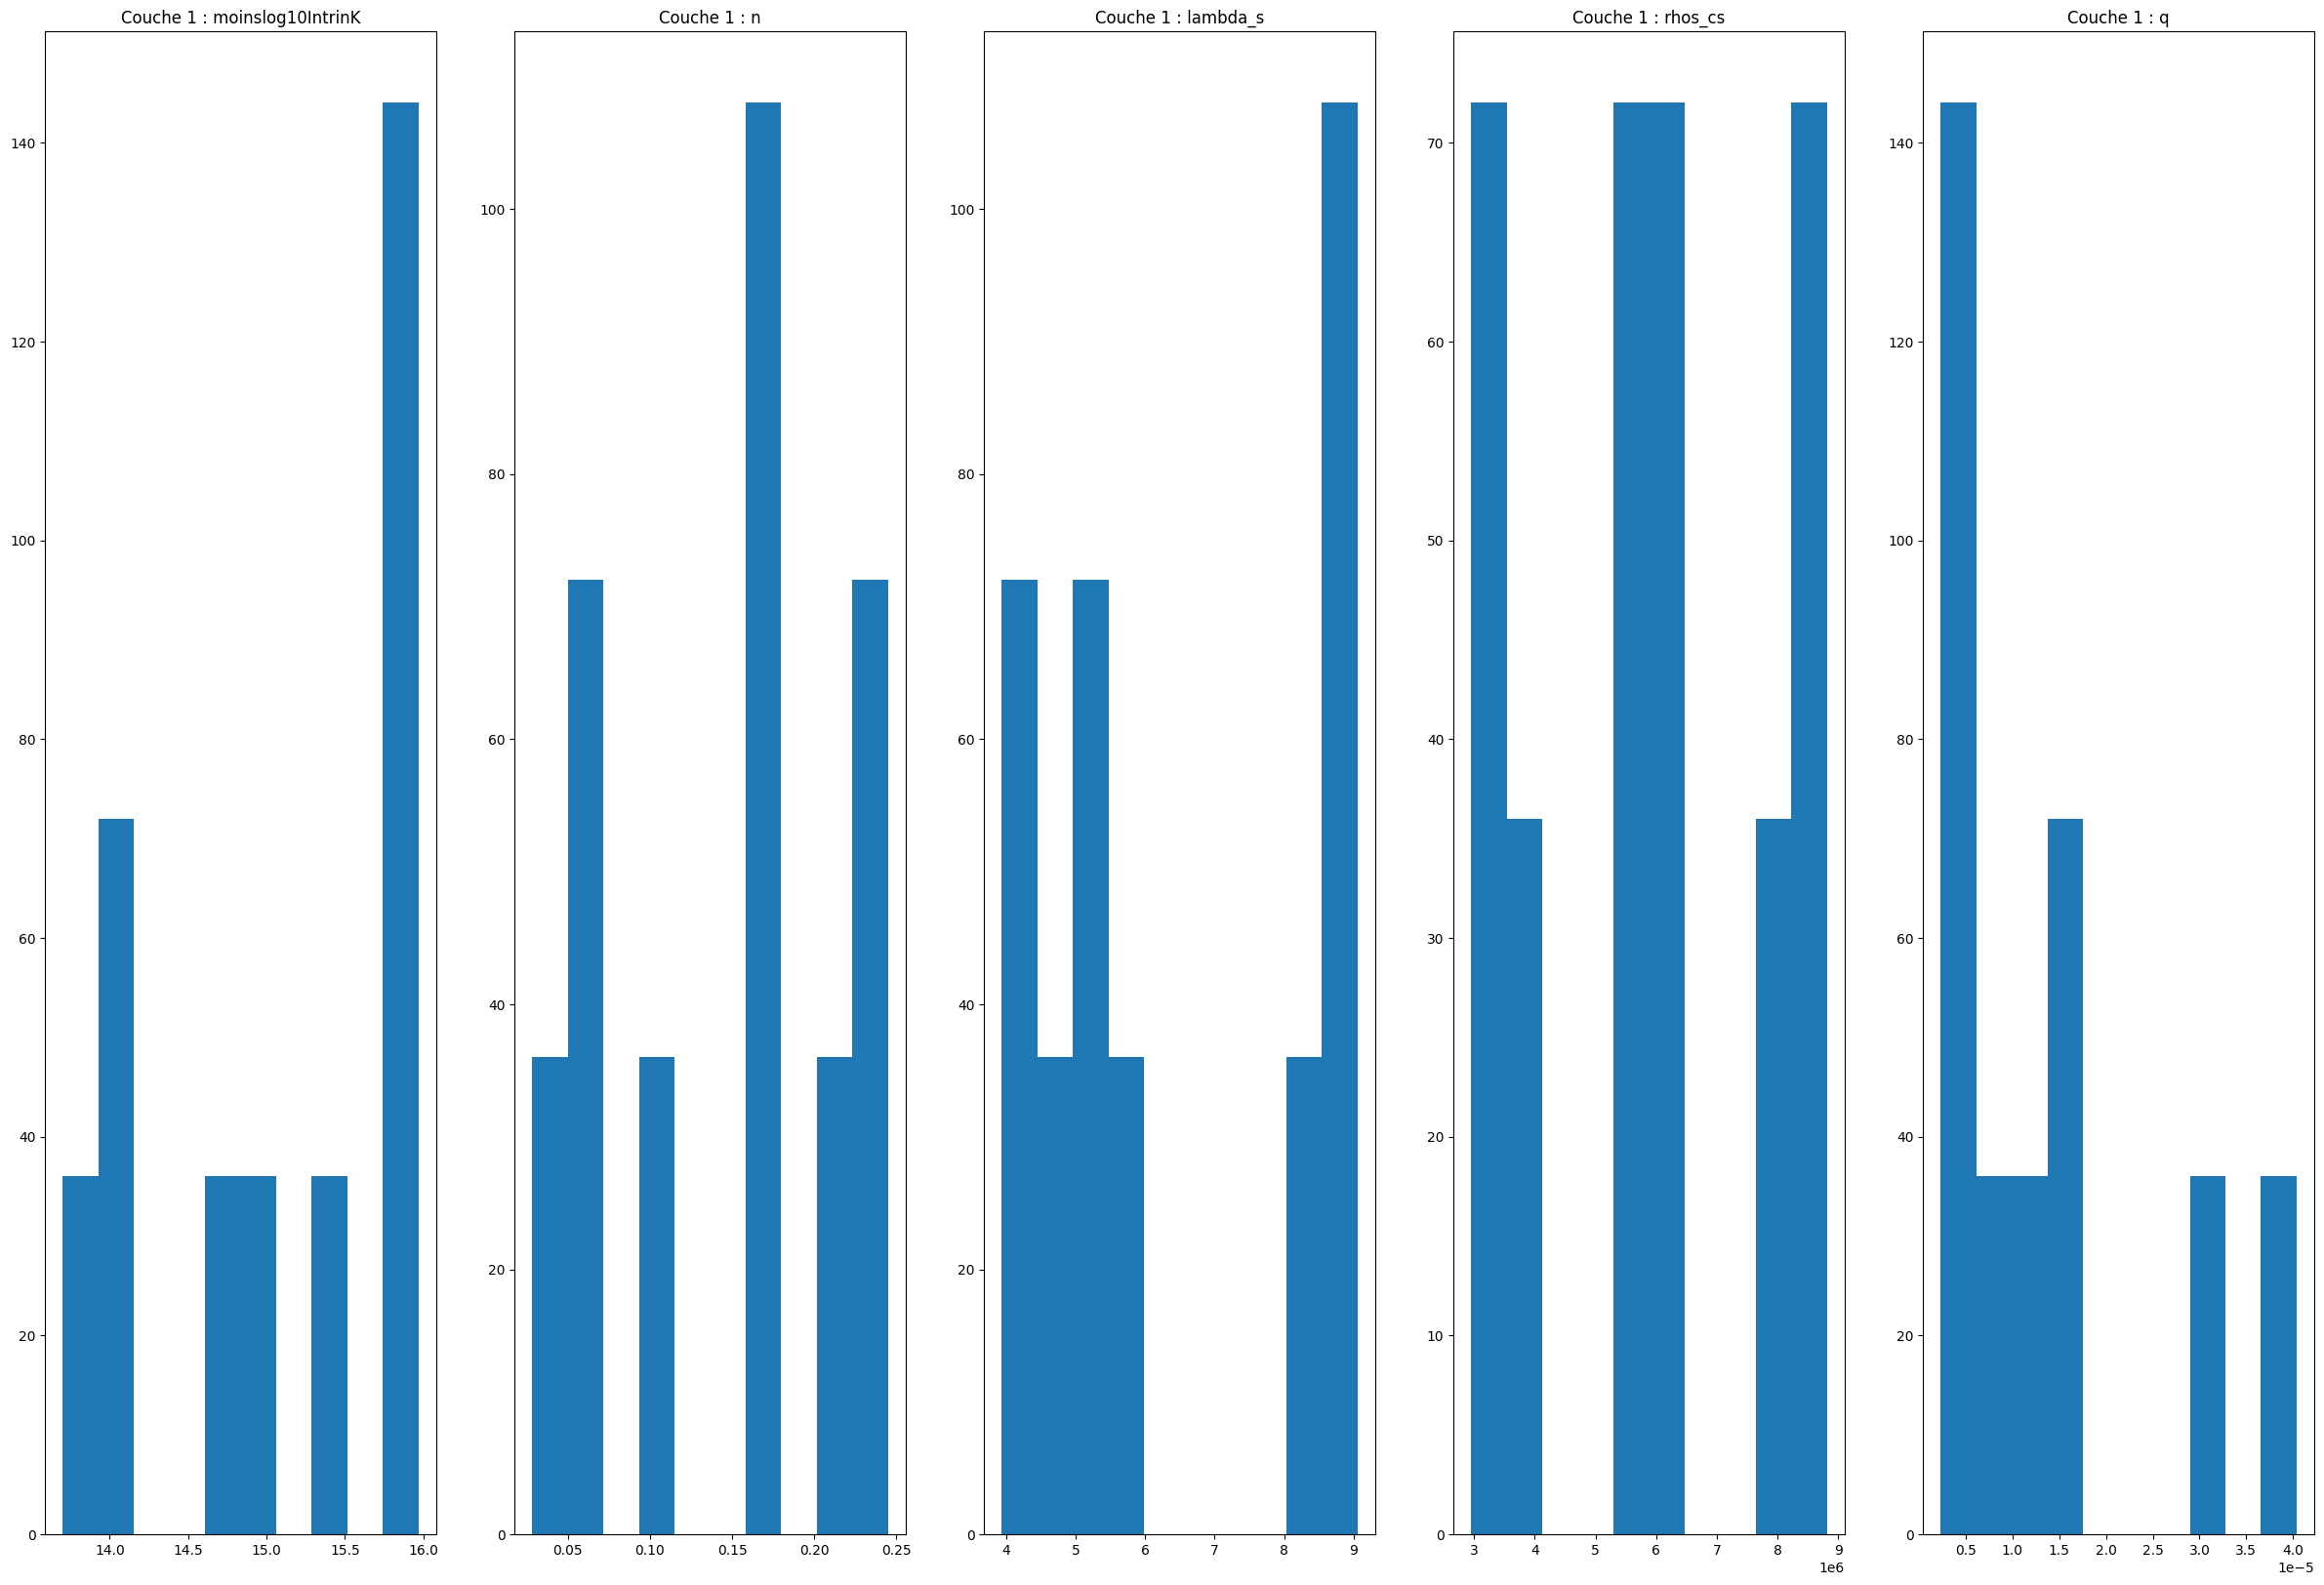

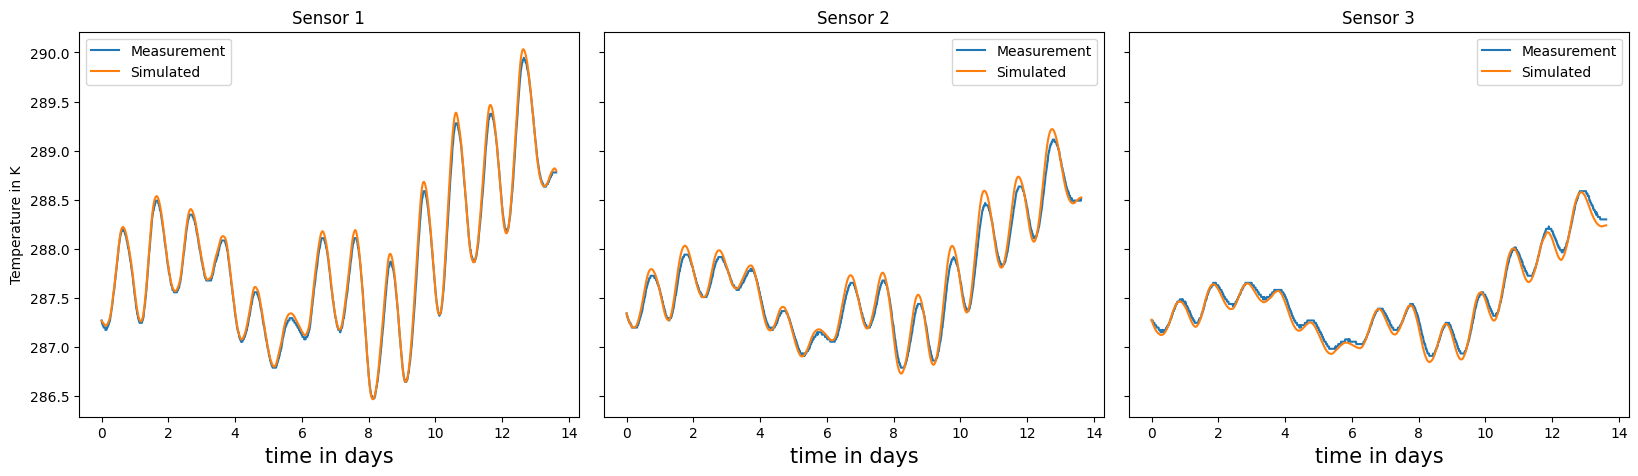

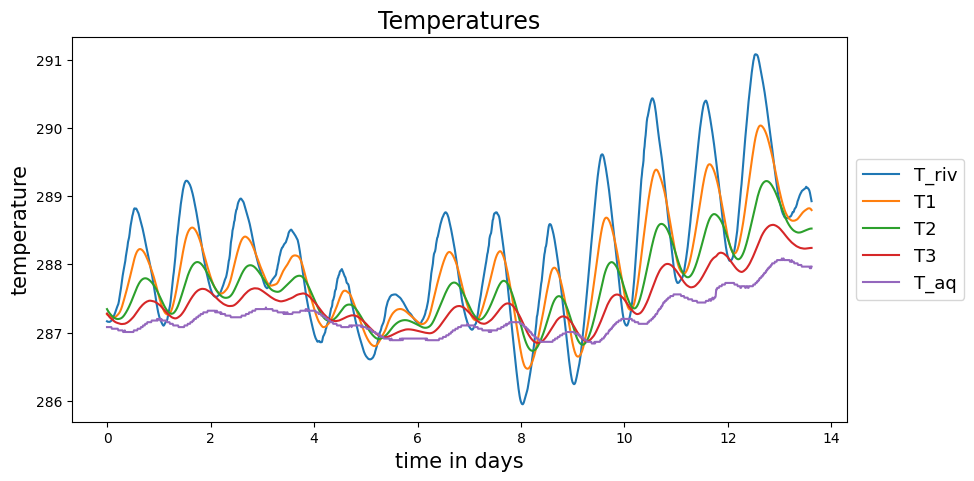

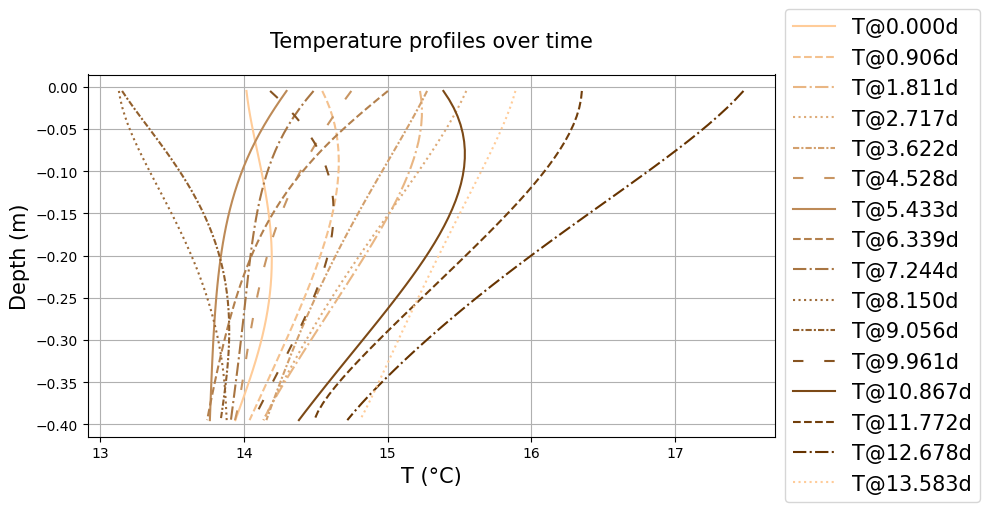

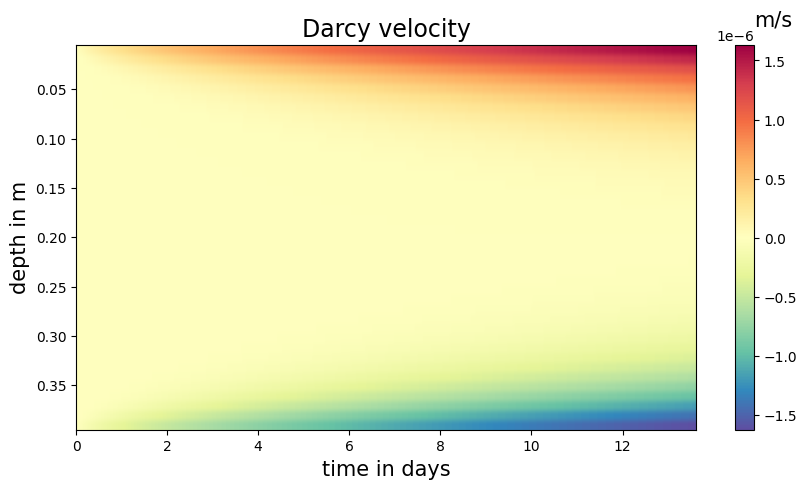

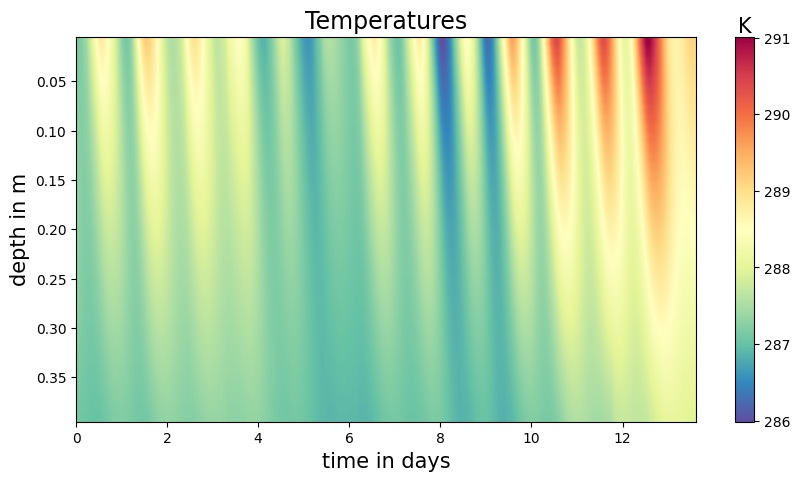

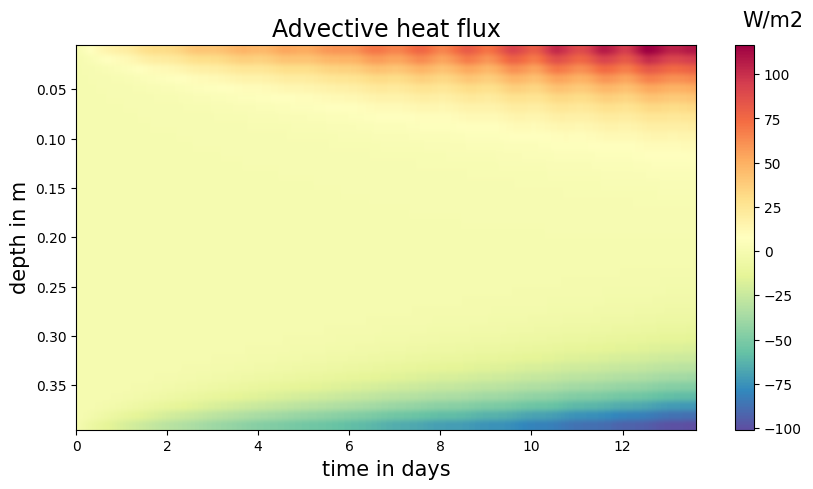

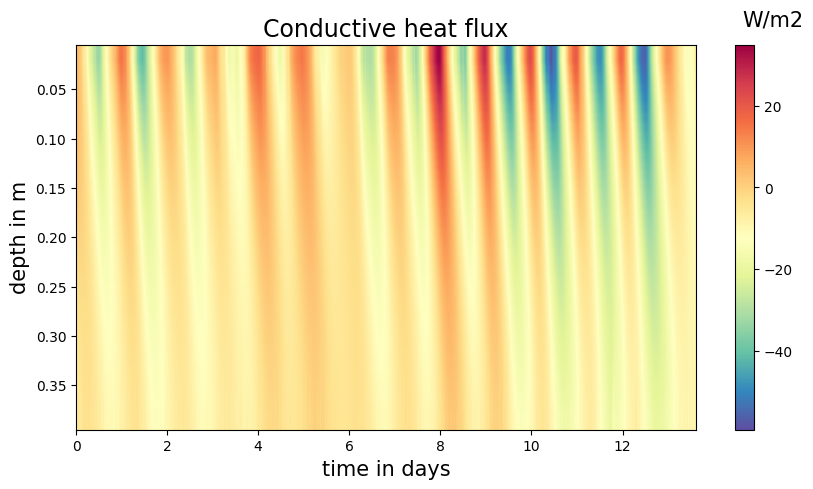

Plotting Température in column. time series have nrecords =  1309


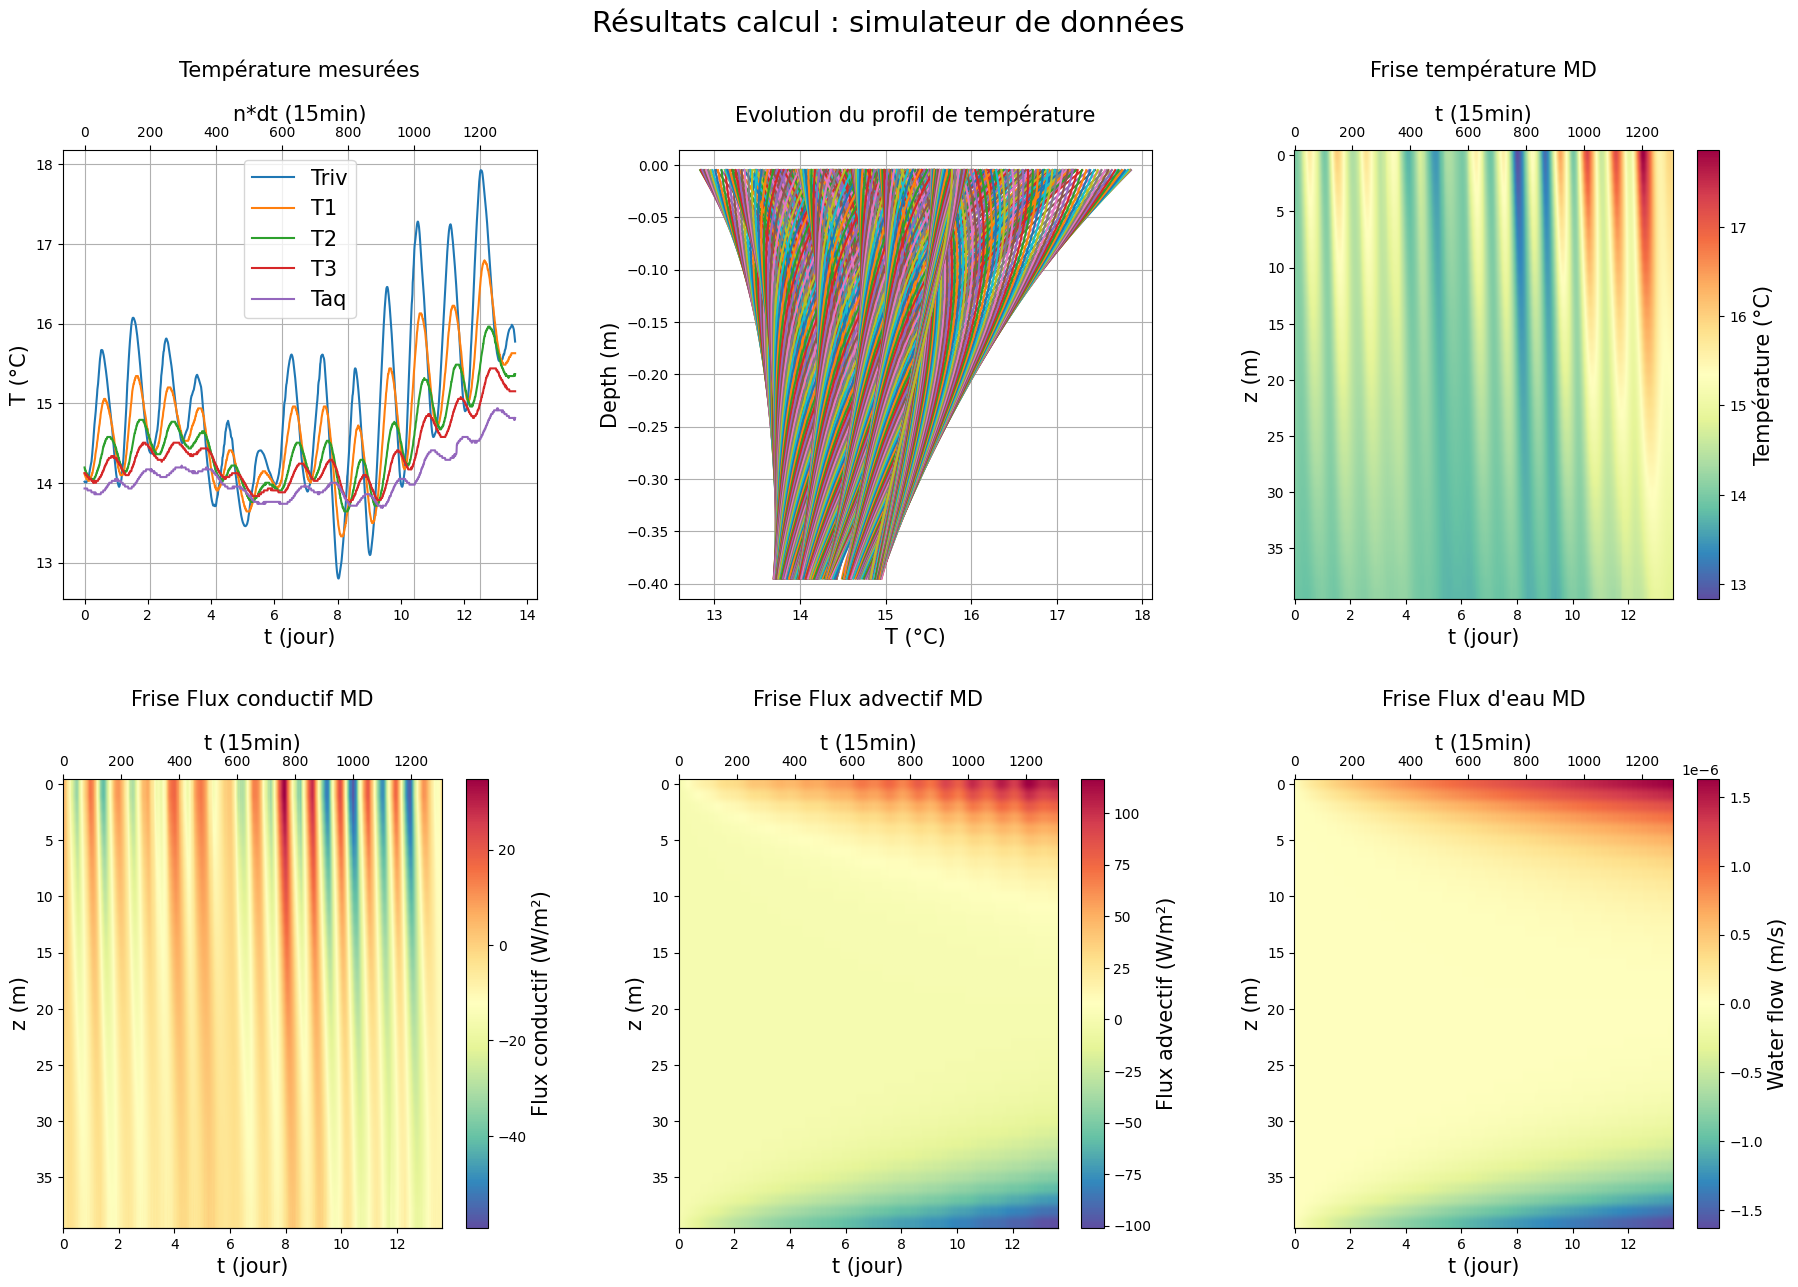

In [59]:
col.plot_all_param_pdf()
print(f"acceptance : {col._acceptance[-1]}")
col.plot_all_results()


### 2.3 Quantiles

Une MCMC calcule aussi des quantiles de températures et de débits d'eau. On peut les récupérer de la façon suivante :

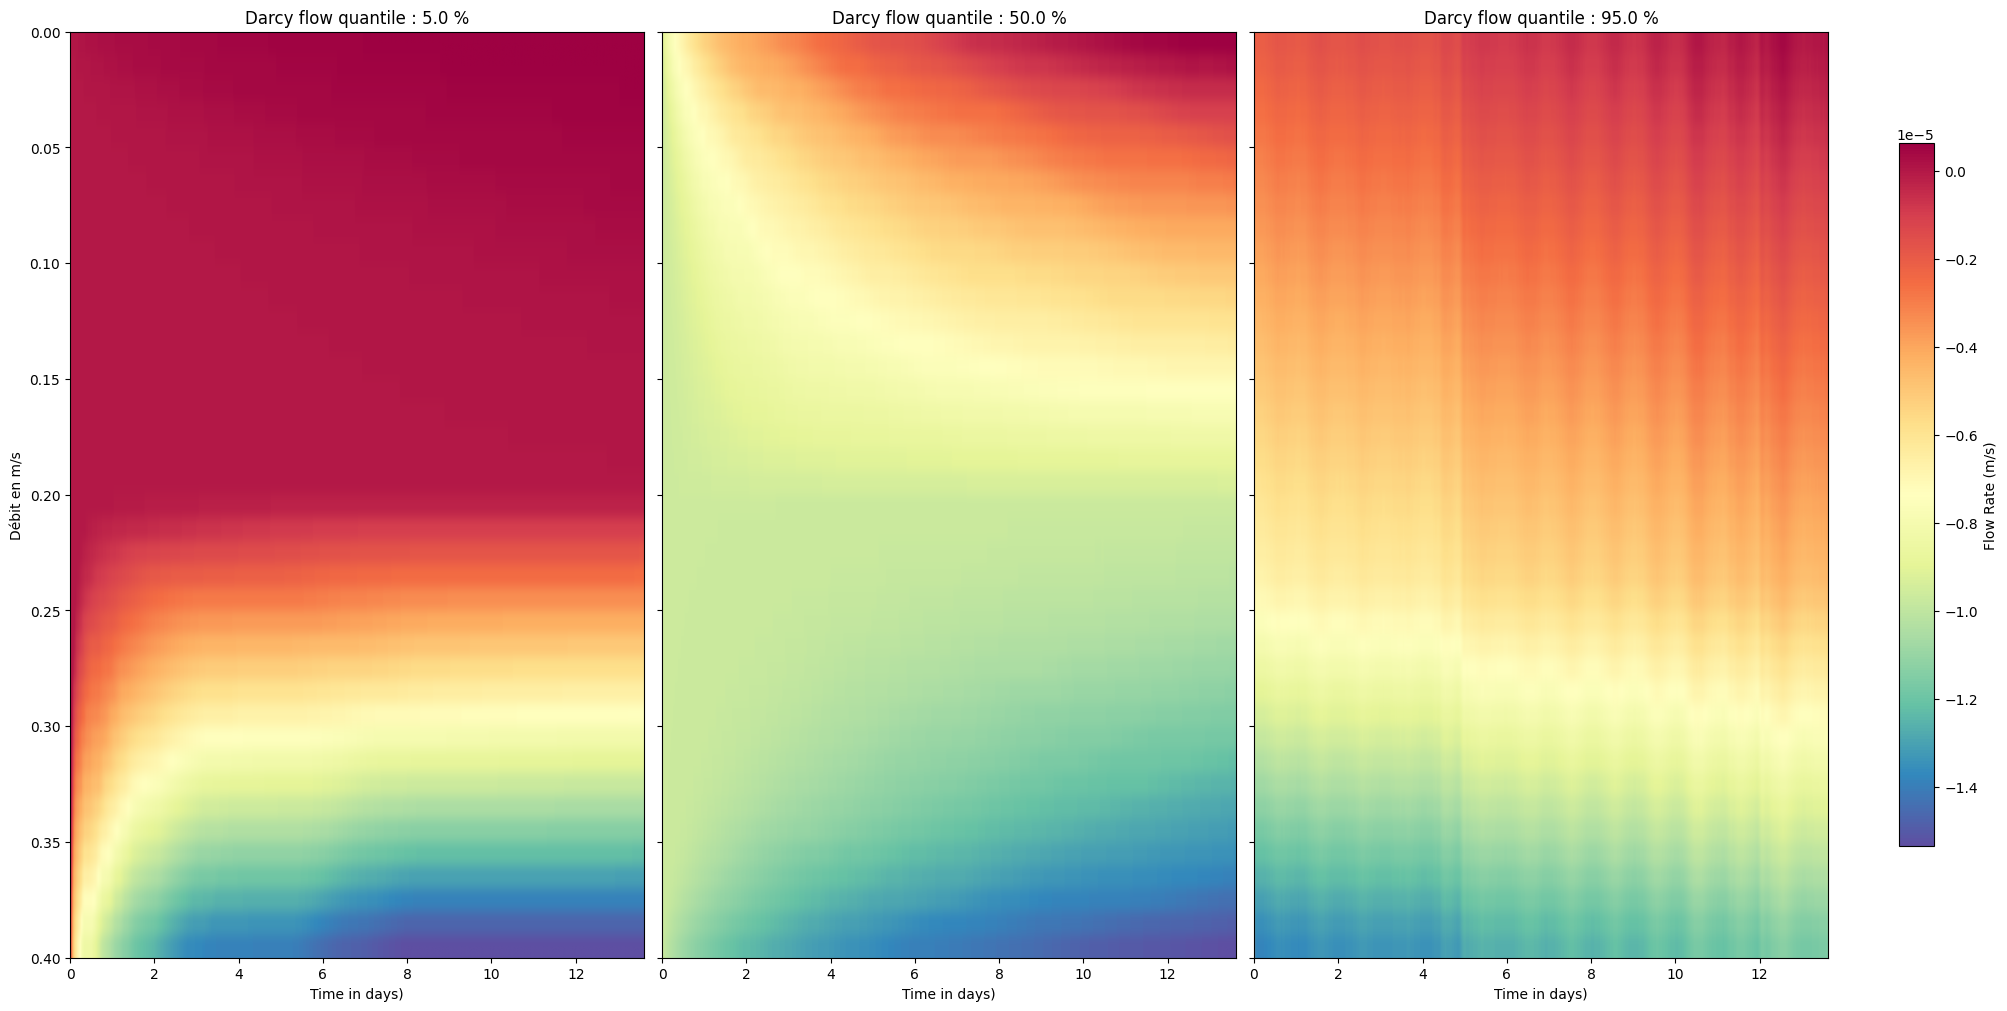

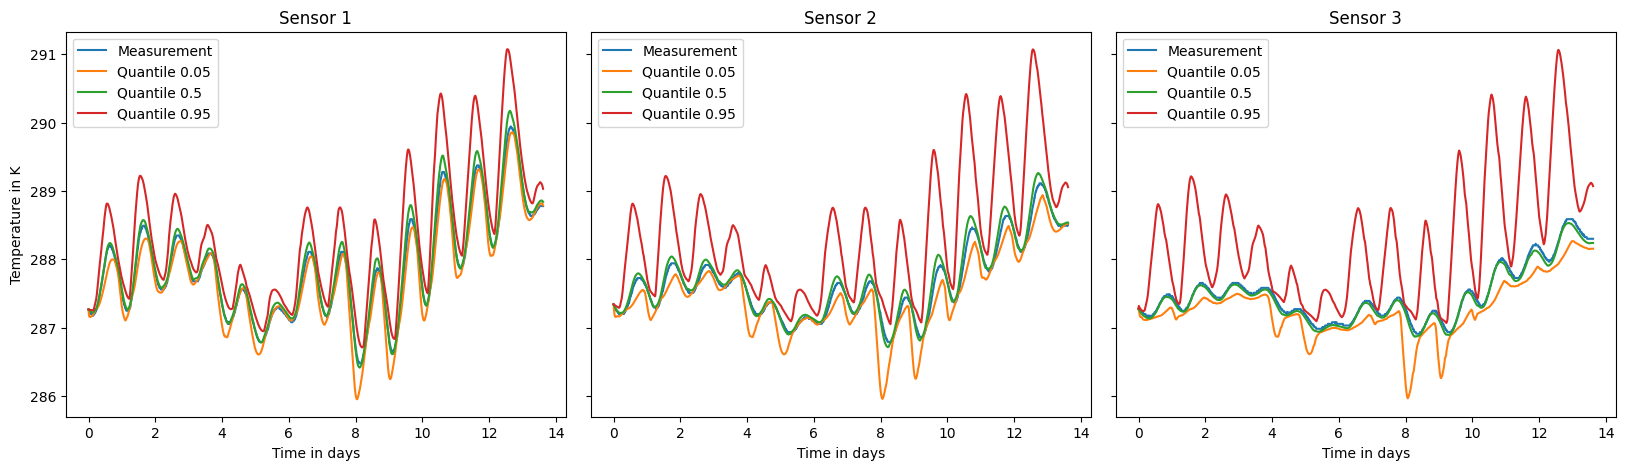

In [60]:
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

On peut aussi regarder les quantiles au niveau des capteurs, et comparer avec les mesures :

## 3. Multilayer Column

### 3.1. Direct Model

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

In [61]:
# PARAMÈTRES (LA VÉRITÉ QUE LA MCMC DOIT TROUVER) 
vrai_params_c1 = Param(moinslog10IntrinK=16.0, n=0.15, lambda_s=2.5, rhos_cs=5e5, q=0)
vrai_params_c2 = Param(moinslog10IntrinK=16.0, n=0.10, lambda_s=2.5, rhos_cs=5e5, q=0)

couche1_vraie = Layer(name="Vraie Couche 1", zLow=1.0)
couche1_vraie.params = vrai_params_c1
couche2_vraie = Layer(name="Vraie Couche 2", zLow=RIVER_BED_DEPTH)
couche2_vraie.params = vrai_params_c2

mes_couches_vraies = [couche1_vraie, couche2_vraie]

# --- Génération des conditions aux limites (Rivière, Aquifère, Charge) ---
times = [
    START_DATE + timedelta(minutes=i * TIMESTEP_MINUTES) for i in range(NB_TIMESTEPS)
]
time_array = np.linspace(0, 8 * np.pi, NB_TIMESTEPS)  # Plus d'oscillations
T_riv = 15 + 5 * np.sin(time_array) + np.random.randn(NB_TIMESTEPS) * 0.2
T_aq = 12.0 + np.random.randn(NB_TIMESTEPS) * 0.1
dH = 1.0 + 0.2 * np.sin(time_array / 2)

# Formatage des conditions limites
dH_measures = []
for i in range(NB_TIMESTEPS):
    dH_measures.append((times[i], (dH[i], T_riv[i])))

Puis on appelle le modèle direct :

RMSE at sensor 0 : 0.053701137228347066
RMSE at sensor 1 : 0.07316753412308816
RMSE at sensor 2 : 0.0468598967692571
Total RMSE : 0.05897216890052591


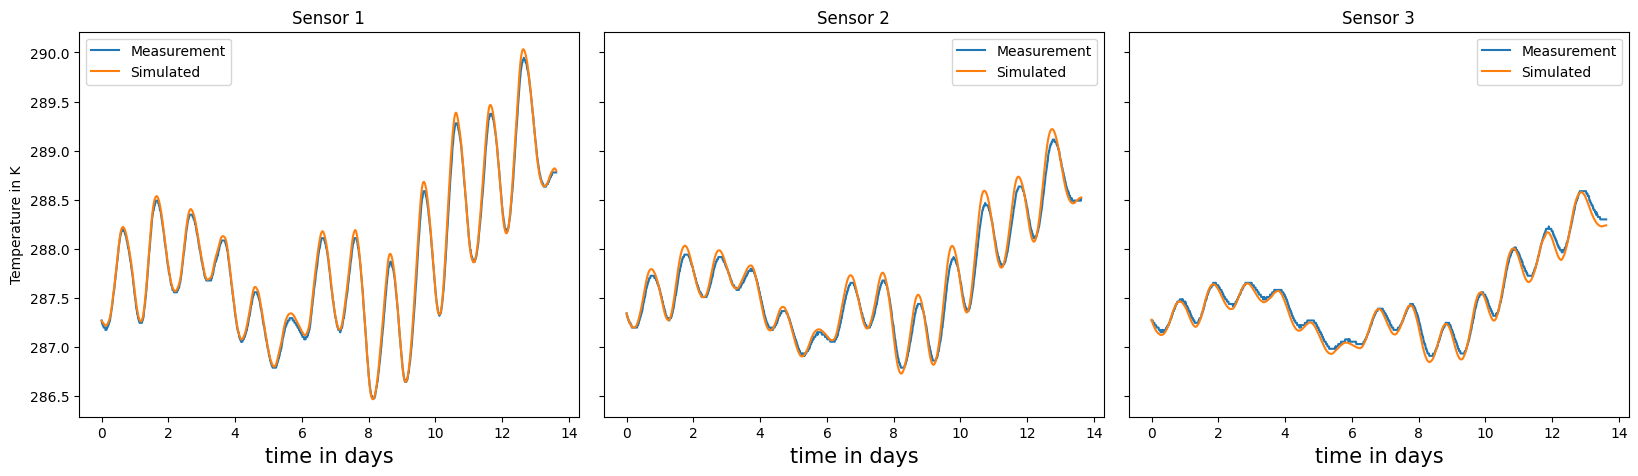

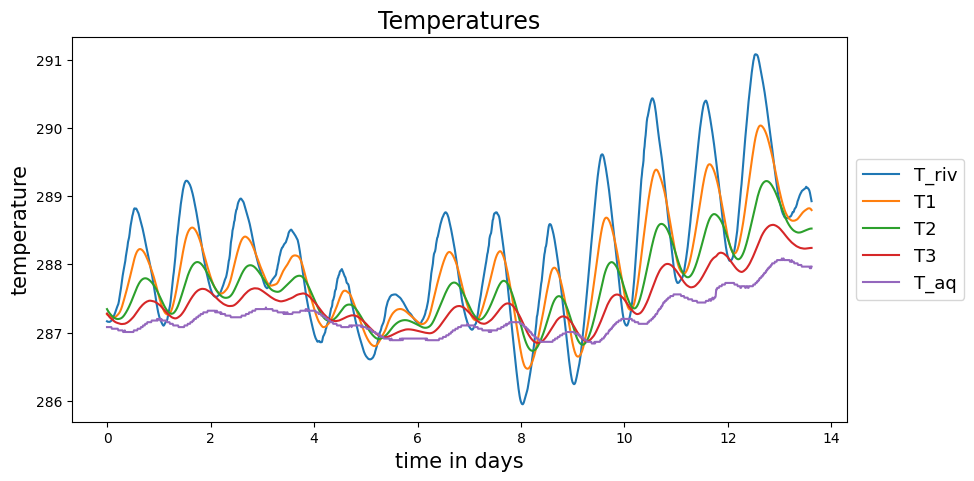

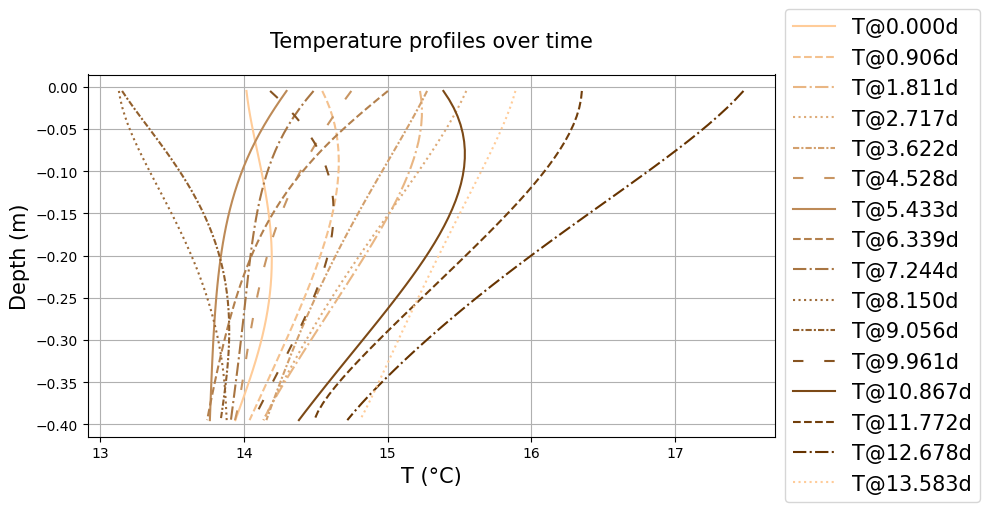

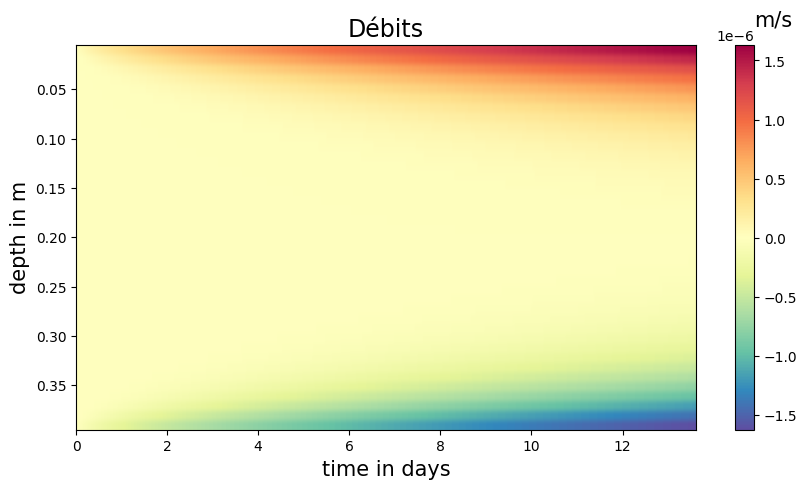

In [62]:
col.compute_solve_transi(verbose=False)

col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()
col.plot_temperature_at_sensors()
nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))
flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

In [63]:
# EXÉCUTION DE LA SIMULATION "VÉRITÉ" POUR CRÉER LES MESURES

# On crée une première colonne "col_reponse" juste pour générer les données cibles
# On doit lui fournir des T_measures factices pour qu'elle s'initialise
T_measures_factices = [(times[i], [10, 10, 10, 10]) for i in range(NB_TIMESTEPS)]

col_reponse = Column(
    river_bed=RIVER_BED_DEPTH,
    depth_sensors=DEPTH_SENSORS_ET_FOND,
    offset=OFFSET,
    dH_measures=dH_measures,
    T_measures=T_measures_factices,  # Utilise les données factices
    all_layers=mes_couches_vraies,  # Utilise les "vrais" paramètres
    verbose=False,
    nb_cells=NBCELLS,
)

# Lancement de la simulation "parfaite"
col_reponse.compute_solve_transi(verbose=False)

# Extraction des températures parfaites aux capteurs
# get_temperature_at_sensors() renvoie [T_riv, T1, T2, T3, T_aq] (5 lignes)
# On ne veut que les capteurs et l'aquifère [T1, T2, T3, T_aq] (4 lignes)
temp_parfaites_matrice = col_reponse.get_temperature_at_sensors()
temp_parfaites_capteurs = temp_parfaites_matrice[1:, :]

# Ajout d'un bruit réaliste pour simuler des "mesures"
bruit = np.random.normal(0, NOISE_LEVEL, temp_parfaites_capteurs.shape)
temp_mesures_bruitees = temp_parfaites_capteurs + bruit

# Re-formatage des "vraies" mesures pour la MCMC
T_measures_realistes = []
for i in range(NB_TIMESTEPS):
    # [T1_bruit, T2_bruit, T3_bruit, T_aq_bruit]
    full_temp_list = temp_mesures_bruitees[:, i].tolist()
    T_measures_realistes.append((times[i], full_temp_list))

print("   -> Données de 'mesure' physiquement réalistes générées.")

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
   -> Données de 'mesure' physiquement réalistes générées.



2. Création de l'instance 'Test' (avec mauvais paramètres initiaux)...
   -> Instance créée.

3. Configuration de l'optimisation MCMC
   -> Priors assignés.
   -> Lancement de la MCMC 
--- Compute MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 12 et 15 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 0.05 et 0.25 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 1 et 5 avec un écart type de 0.1, Prior sur une valeure qui évolue entre 1000000.0 et 5000000.0 avec un écart type de 100000.0, Prior sur une valeure qui évolue entre -1e-06 et 1e-06 avec un écart type de 1e-10]
    [Prior sur une valeure qui évolue entre 12 et 15 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 0.05 et 0.25 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 1 et 5 avec un écart type de 0.1, Prior sur une valeure qui évolue entre 1000000.0 et 5000000.0 avec un écart type de 100000.0, Prior sur une valeure qui évolue entre -1e-0

Burn in phase:   0%|          | 0/500 [00:00<?, ?it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   1%|          | 3/500 [00:00<00:23, 21.13it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   1%|          | 6/500 [00:00<00:23, 20.98it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   2%|▏         | 9/500 [00:00<00:23, 21.03it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   2%|▏         | 12/500 [00:00<00:23, 21.07it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   3%|▎         | 15/500 [00:00<00:23, 21.04it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   4%|▎         | 18/500 [00:00<00:22, 21.09it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---


Burn in phase:   4%|▍         | 21/500 [00:00<00:22, 21.11it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   5%|▍         | 24/500 [00:01<00:22, 20.97it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   5%|▌         | 27/500 [00:01<00:22, 20.68it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   6%|▌         | 30/500 [00:01<00:22, 20.79it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   7%|▋         | 33/500 [00:01<00:22, 20.84it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   7%|▋         | 36/500 [00:01<00:23, 20.13it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   8%|▊         | 39/500 [00:01<00:22, 20.08it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   8%|▊         | 42/500 [00:02<00:23, 19.91it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   9%|▉         | 44/500 [00:02<00:22, 19.88it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:   9%|▉         | 46/500 [00:02<00:22, 19.85it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  10%|▉         | 48/500 [00:02<00:22, 19.83it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  10%|█         | 50/500 [00:02<00:22, 19.79it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  10%|█         | 52/500 [00:02<00:22, 19.82it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  11%|█         | 56/500 [00:02<00:22, 19.70it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  12%|█▏        | 60/500 [00:02<00:22, 19.18it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  13%|█▎        | 64/500 [00:03<00:22, 19.12it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  14%|█▎        | 68/500 [00:03<00:27, 15.80it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  14%|█▍        | 72/500 [00:03<00:24, 17.18it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  15%|█▌        | 75/500 [00:03<00:23, 18.28it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  15%|█▌        | 77/500 [00:03<00:22, 18.56it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  16%|█▌        | 79/500 [00:04<00:22, 18.50it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  16%|█▌        | 81/500 [00:04<00:22, 18.45it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  17%|█▋        | 83/500 [00:04<00:24, 17.06it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  17%|█▋        | 85/500 [00:04<00:23, 17.44it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  17%|█▋        | 87/500 [00:04<00:23, 17.89it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  18%|█▊        | 89/500 [00:04<00:22, 18.34it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  18%|█▊        | 91/500 [00:04<00:21, 18.63it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  19%|█▊        | 93/500 [00:04<00:21, 18.68it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---


Burn in phase:  19%|█▉        | 95/500 [00:04<00:21, 18.41it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  19%|█▉        | 97/500 [00:05<00:21, 18.44it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---


Burn in phase:  20%|█▉        | 99/500 [00:05<00:21, 18.38it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  21%|██        | 104/500 [00:05<00:21, 18.77it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  22%|██▏       | 108/500 [00:05<00:22, 17.61it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  22%|██▏       | 112/500 [00:05<00:21, 18.03it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  23%|██▎       | 116/500 [00:06<00:20, 18.54it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  24%|██▍       | 120/500 [00:06<00:20, 18.55it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  25%|██▍       | 124/500 [00:06<00:20, 18.49it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  26%|██▌       | 128/500 [00:06<00:19, 18.91it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  26%|██▋       | 132/500 [00:06<00:19, 18.48it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  27%|██▋       | 135/500 [00:07<00:19, 19.16it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  28%|██▊       | 141/500 [00:07<00:18, 19.81it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  29%|██▉       | 144/500 [00:07<00:17, 19.96it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  30%|███       | 150/500 [00:07<00:17, 20.16it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  31%|███       | 153/500 [00:07<00:17, 20.18it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  32%|███▏      | 158/500 [00:08<00:17, 19.67it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  32%|███▏      | 162/500 [00:08<00:18, 18.64it/s]


---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (

Burn in phase:  33%|███▎      | 166/500 [00:08<00:17, 19.06it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  34%|███▍      | 171/500 [00:08<00:16, 19.61it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  35%|███▍      | 173/500 [00:09<00:17, 19.02it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  36%|███▌      | 179/500 [00:09<00:16, 19.69it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  36%|███▌      | 181/500 [00:09<00:16, 19.75it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  37%|███▋      | 186/500 [00:09<00:16, 19.02it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  38%|███▊      | 191/500 [00:09<00:15, 19.51it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  39%|███▉      | 197/500 [00:10<00:15, 20.00it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  40%|████      | 200/500 [00:10<00:14, 20.13it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  41%|████      | 206/500 [00:10<00:14, 20.17it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  42%|████▏     | 209/500 [00:10<00:14, 20.27it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  43%|████▎     | 214/500 [00:11<00:14, 19.53it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  44%|████▍     | 219/500 [00:11<00:14, 19.53it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  44%|████▍     | 222/500 [00:11<00:14, 19.79it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  46%|████▌     | 228/500 [00:11<00:13, 20.05it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  46%|████▌     | 231/500 [00:11<00:13, 20.12it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  47%|████▋     | 234/500 [00:12<00:13, 20.08it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  48%|████▊     | 240/500 [00:12<00:13, 19.46it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  49%|████▉     | 246/500 [00:12<00:12, 19.97it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  50%|████▉     | 249/500 [00:12<00:12, 20.10it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  50%|█████     | 252/500 [00:12<00:12, 20.10it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  51%|█████▏    | 257/500 [00:13<00:12, 19.62it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  53%|█████▎    | 263/500 [00:13<00:11, 20.02it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  53%|█████▎    | 266/500 [00:13<00:12, 19.43it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  54%|█████▍    | 269/500 [00:13<00:11, 19.57it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  55%|█████▍    | 274/500 [00:14<00:11, 19.72it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  56%|█████▌    | 280/500 [00:14<00:10, 20.07it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  57%|█████▋    | 283/500 [00:14<00:10, 20.09it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  57%|█████▋    | 286/500 [00:14<00:10, 20.06it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  58%|█████▊    | 291/500 [00:14<00:10, 19.49it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  59%|█████▉    | 297/500 [00:15<00:10, 19.90it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  60%|█████▉    | 299/500 [00:15<00:10, 19.92it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  61%|██████    | 305/500 [00:15<00:09, 19.98it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  62%|██████▏   | 310/500 [00:15<00:09, 20.08it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  63%|██████▎   | 313/500 [00:16<00:09, 19.27it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  63%|██████▎   | 317/500 [00:16<00:09, 19.41it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  65%|██████▍   | 323/500 [00:16<00:08, 19.82it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  65%|██████▌   | 327/500 [00:16<00:08, 19.82it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  66%|██████▌   | 329/500 [00:16<00:08, 19.83it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  67%|██████▋   | 334/500 [00:17<00:08, 18.92it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  67%|██████▋   | 337/500 [00:17<00:08, 19.37it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  68%|██████▊   | 342/500 [00:17<00:08, 19.60it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  69%|██████▉   | 347/500 [00:17<00:07, 19.80it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  71%|███████   | 353/500 [00:18<00:07, 19.99it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  71%|███████▏  | 357/500 [00:18<00:07, 19.07it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  72%|███████▏  | 359/500 [00:18<00:07, 19.23it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  73%|███████▎  | 364/500 [00:18<00:06, 19.66it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  74%|███████▍  | 370/500 [00:18<00:06, 19.92it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  75%|███████▍  | 374/500 [00:19<00:06, 19.32it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  76%|███████▌  | 378/500 [00:19<00:06, 19.56it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  76%|███████▋  | 382/500 [00:19<00:06, 19.09it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  77%|███████▋  | 384/500 [00:19<00:06, 19.33it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  78%|███████▊  | 389/500 [00:19<00:05, 19.67it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  79%|███████▉  | 394/500 [00:20<00:05, 19.77it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  80%|███████▉  | 399/500 [00:20<00:05, 19.94it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  81%|████████  | 403/500 [00:20<00:05, 18.94it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  81%|████████▏ | 407/500 [00:20<00:04, 19.26it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  82%|████████▏ | 411/500 [00:21<00:04, 19.52it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  83%|████████▎ | 416/500 [00:21<00:04, 19.78it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  84%|████████▍ | 420/500 [00:21<00:04, 19.79it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  85%|████████▍ | 424/500 [00:21<00:04, 18.94it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  86%|████████▌ | 428/500 [00:21<00:03, 19.26it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  86%|████████▋ | 432/500 [00:22<00:03, 19.57it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  87%|████████▋ | 436/500 [00:22<00:03, 19.53it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  88%|████████▊ | 441/500 [00:22<00:02, 19.70it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  89%|████████▉ | 445/500 [00:22<00:02, 18.98it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  90%|█████████ | 450/500 [00:23<00:02, 19.50it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  91%|█████████ | 454/500 [00:23<00:02, 19.65it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  92%|█████████▏| 458/500 [00:23<00:02, 19.72it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  92%|█████████▏| 462/500 [00:23<00:02, 18.81it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  93%|█████████▎| 466/500 [00:23<00:01, 19.18it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  94%|█████████▍| 471/500 [00:24<00:01, 19.56it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  95%|█████████▌| 475/500 [00:24<00:01, 19.64it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  96%|█████████▌| 479/500 [00:24<00:01, 19.61it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  97%|█████████▋| 483/500 [00:24<00:00, 17.69it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  97%|█████████▋| 487/500 [00:25<00:00, 18.61it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  98%|█████████▊| 491/500 [00:25<00:00, 19.09it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase:  99%|█████████▉| 495/500 [00:25<00:00, 18.74it/s]

---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

Burn in phase: 100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (40, 200) ---
---Débogage des dimensions avant la boucle : len(K_list) = 40, nablaH.shape = (4

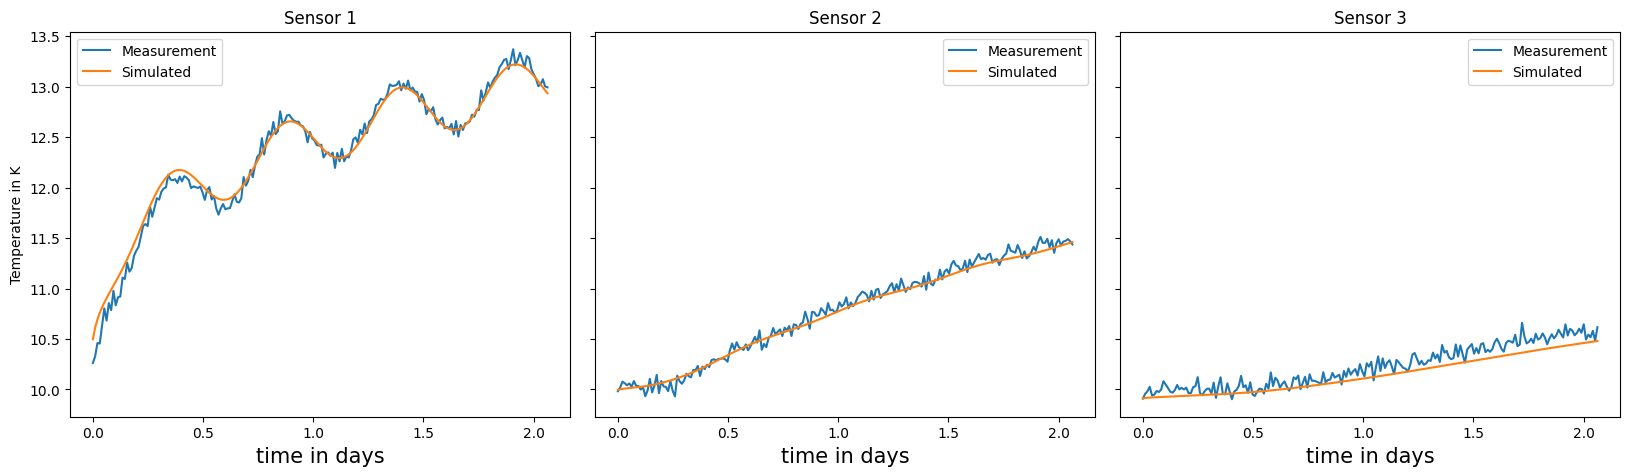

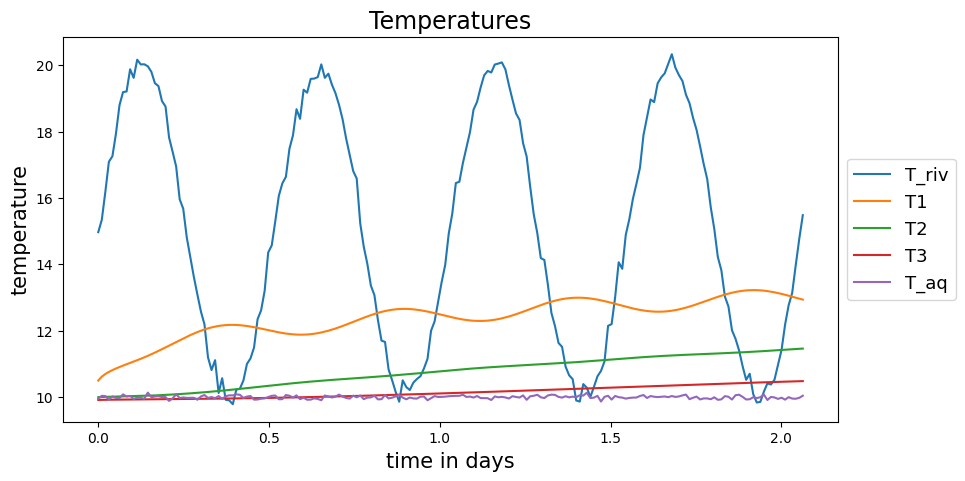

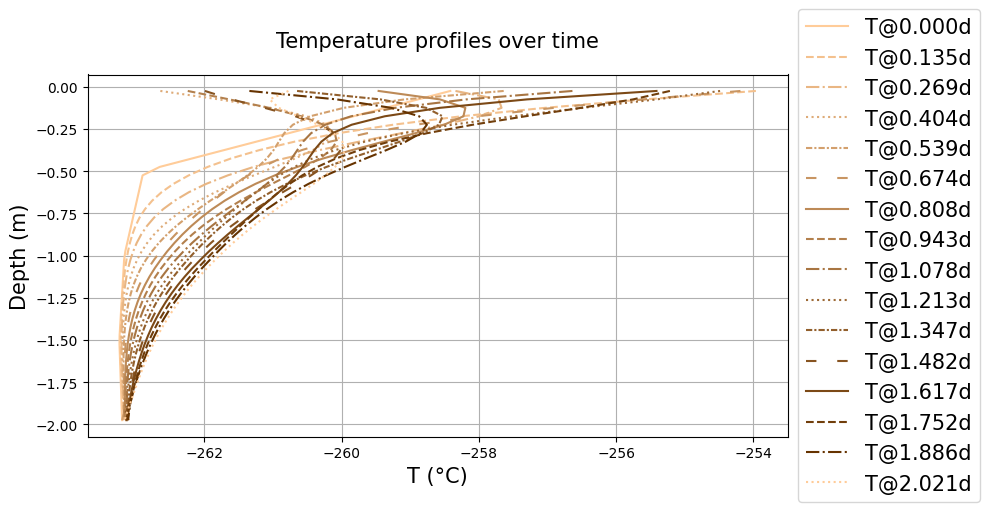

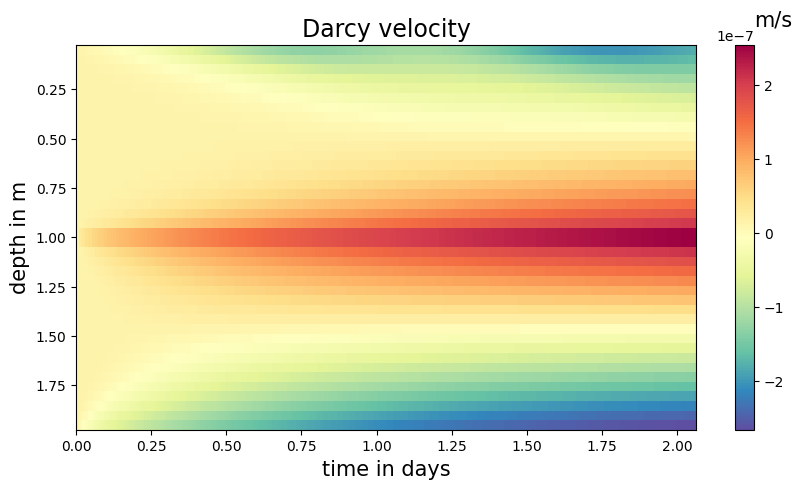

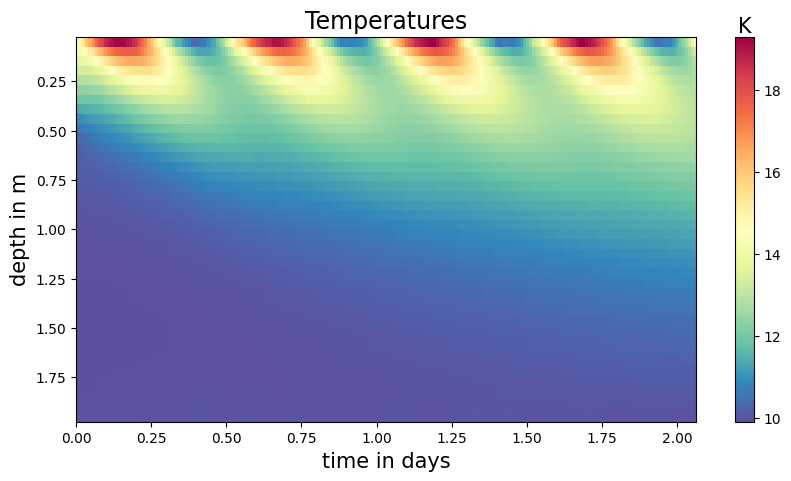

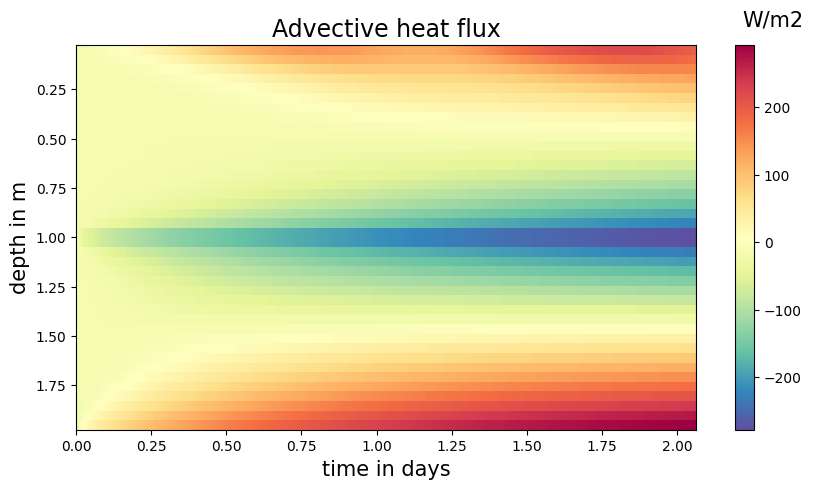

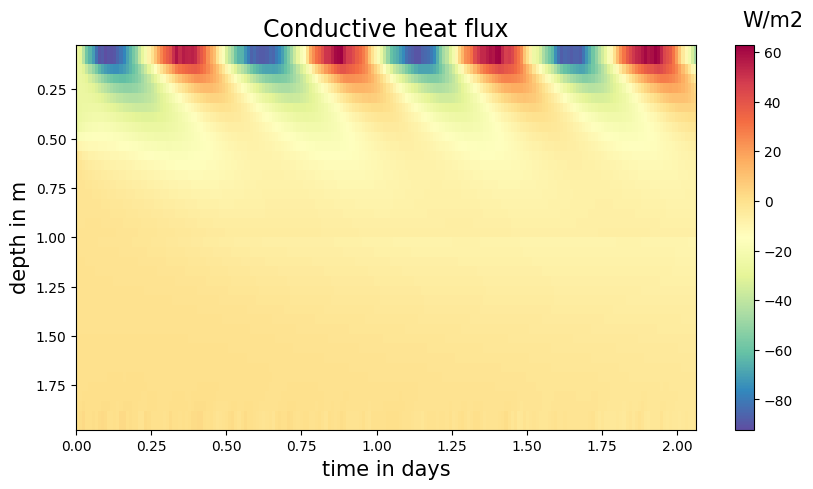

Plotting Température in column. time series have nrecords =  200
   -> Graphiques optimisés générés.

   -> Affichage des distributions de paramètres (PDF) trouvées...

5. ÉVALUATION DES RÉSULTATS MCMC

Paramètres 'vrais' que nous avons définis :
  Couche 1: Param(moinslog10IntrinK=16.0, n=0.15, lambda_s=2.5, rhos_cs=500000.0, q=0)
  Couche 2: Param(moinslog10IntrinK=16.0, n=0.1, lambda_s=2.5, rhos_cs=500000.0, q=0)

Paramètres 'ESTIMÉS' par la MCMC :

Une erreur est survenue pendant la MCMC ou la simulation finale : 'numpy.ndarray' object has no attribute 'params'


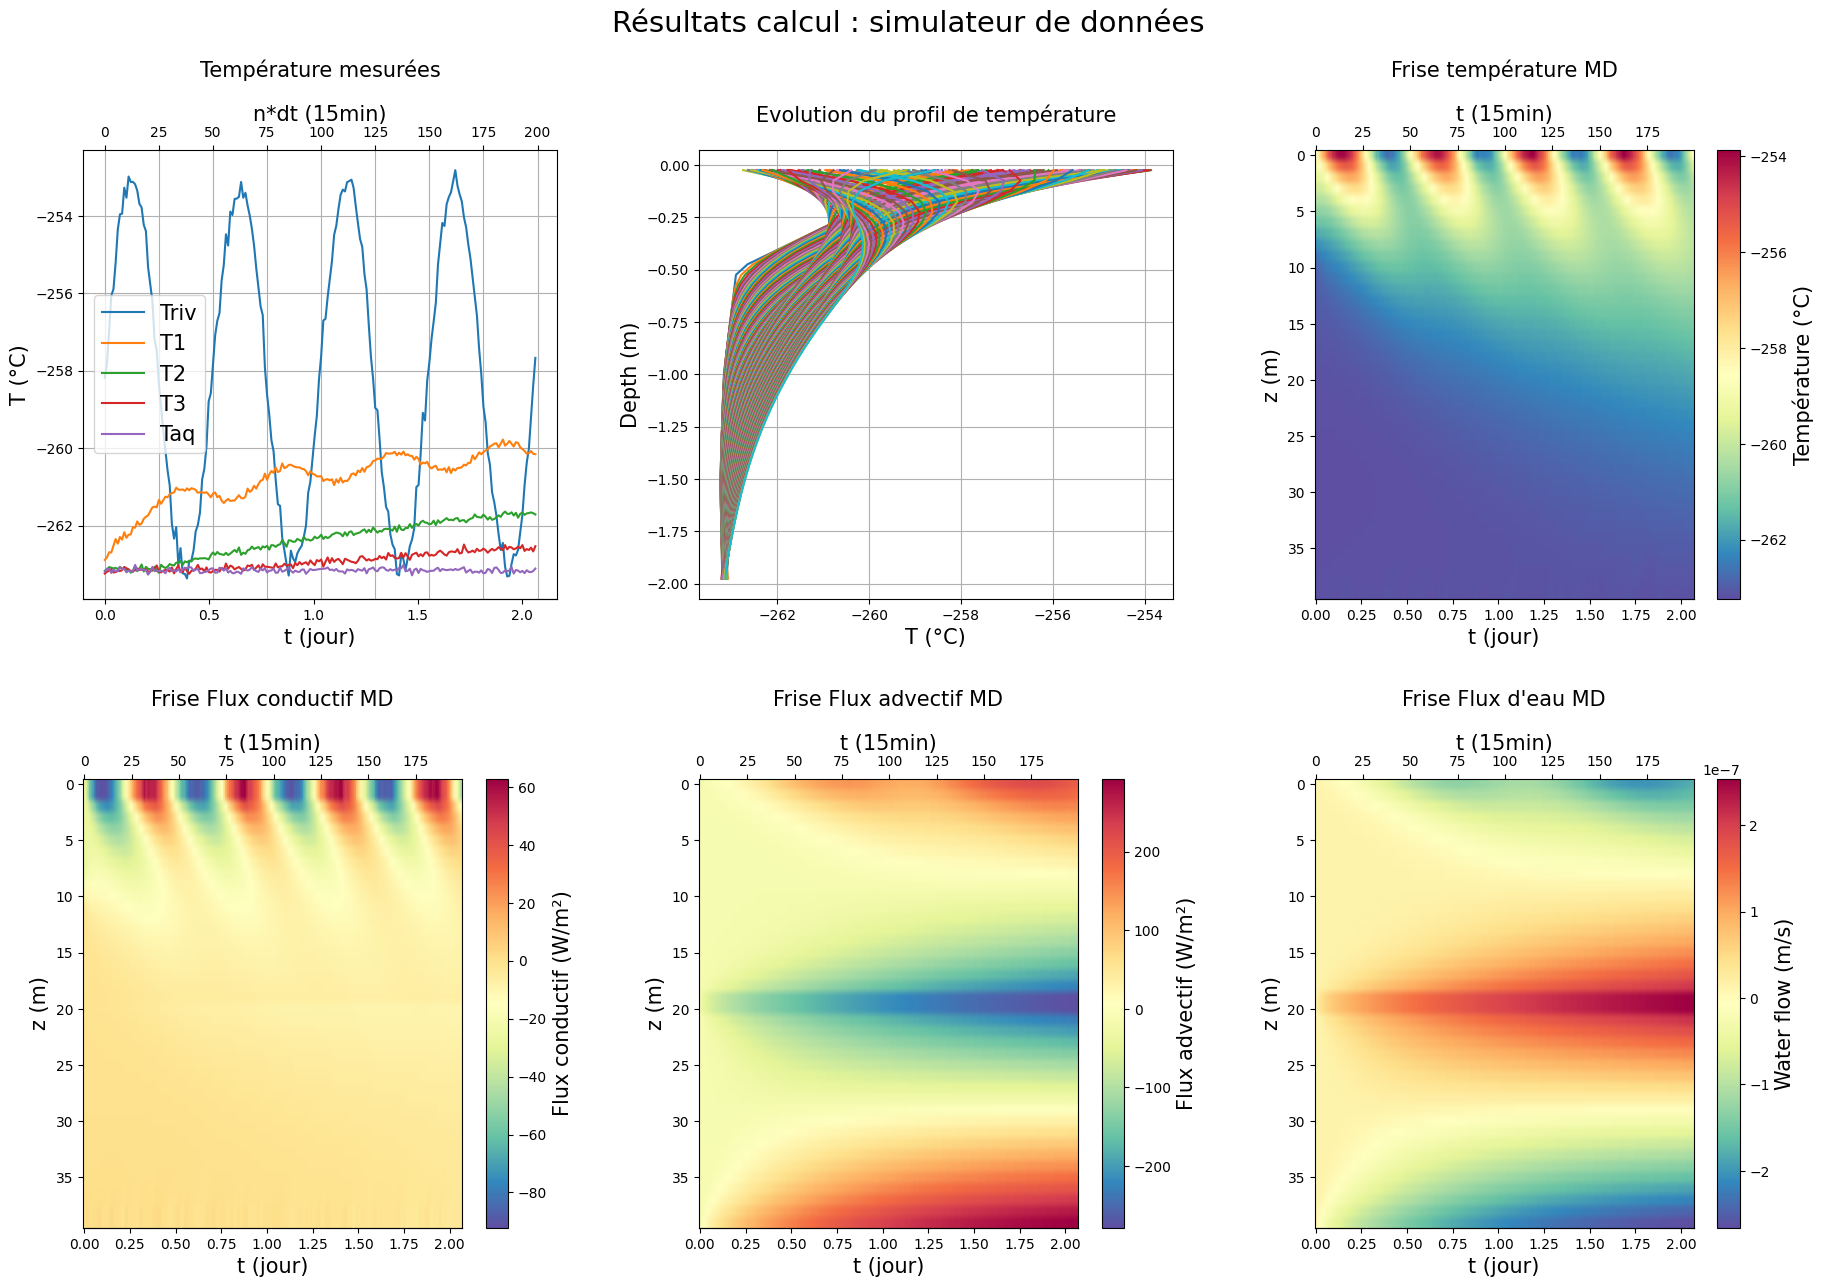

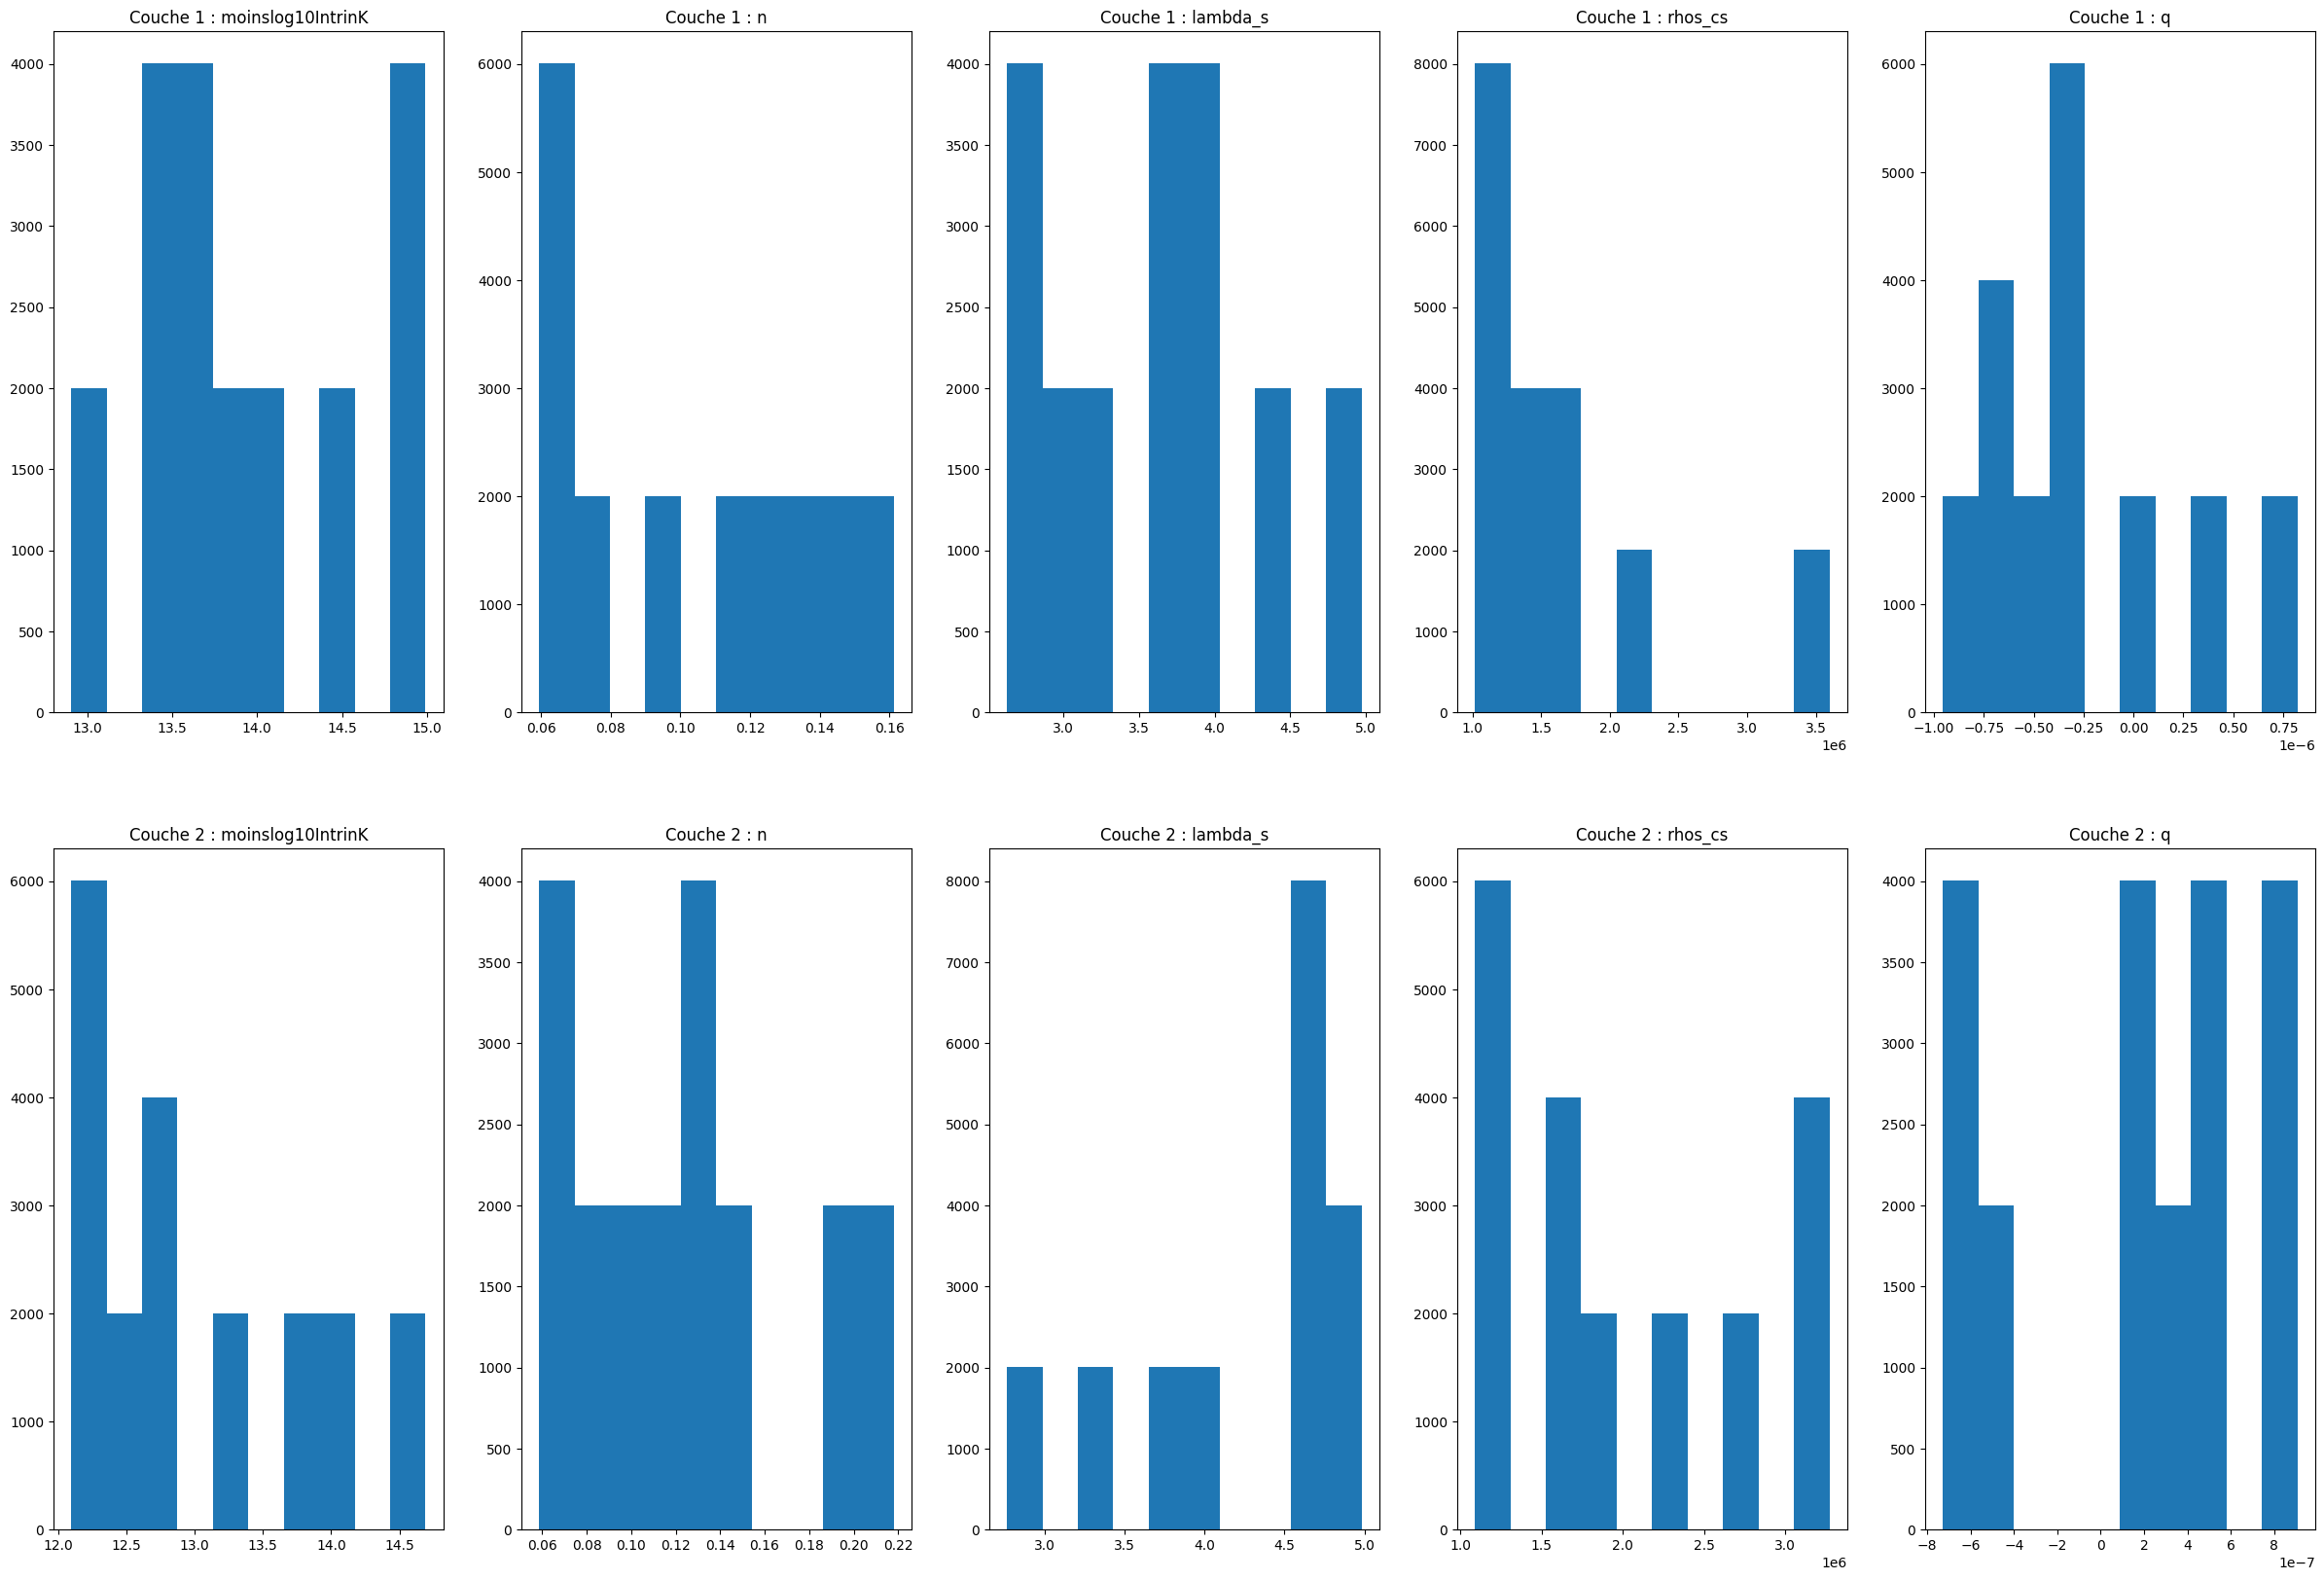

In [64]:
# CONFIGURATION ET EXÉCUTION DE LA MCMC 

if __name__ == "__main__":
    print("\n2. Création de l'instance 'Test' (avec mauvais paramètres initiaux)...")

    # Paramètres initiaux 
    params_test_c1 = Param(moinslog10IntrinK=12, n=0.1, lambda_s=1.0, rhos_cs=1e6, q=0)
    params_test_c2 = Param(moinslog10IntrinK=12, n=0.1, lambda_s=1.0, rhos_cs=1e6, q=0)

    couche1_test = Layer(name="Couche 1 Test", zLow=1.0)
    couche1_test.params = params_test_c1
    couche2_test = Layer(name="Couche 2 Test", zLow=RIVER_BED_DEPTH)
    couche2_test.params = params_test_c2

    # Création de la colonne principale pour la MCMC
    ma_colonne = Column(
        river_bed=RIVER_BED_DEPTH,
        depth_sensors=DEPTH_SENSORS_ET_FOND,
        offset=OFFSET,
        dH_measures=dH_measures,
        T_measures=T_measures_realistes,  
        all_layers=[couche1_test, couche2_test],  
        verbose=False,
        nb_cells=NBCELLS,
    )
    print("   -> Instance créée.")

    print("\n3. Configuration de l'optimisation MCMC")

    # Priors (plages de recherche) qui englobent les "vraies" valeurs
    priors_couche_1 = {
        "Prior_moinslog10IntrinK": ((12, 15), 0.01),  # Vrai: 13.8
        "Prior_n": ((0.05, 0.25), 0.01),  # Vrai: 0.15
        "Prior_lambda_s": ((1, 5), 0.1),  # Vrai: 2.5
        "Prior_rhos_cs": ((1e6, 5e6), 1e5),  # Vrai: 2.5e6
        "Prior_q": ((-1e-6, 1e-6), 1e-10),
    }
    priors_couche_2 = {
        "Prior_moinslog10IntrinK": ((12, 15), 0.01),  # Vrai: 14.5
        "Prior_n": ((0.05, 0.25), 0.01),  # Vrai: 0.10
        "Prior_lambda_s": ((1, 5), 0.1),  # Vrai: 1.8
        "Prior_rhos_cs": ((1e6, 5e6), 1e5),  # Vrai: 3.0e6
        "Prior_q": ((-1e-6, 1e-6), 1e-10),
    }

    try:
        ma_colonne.all_layers[0].set_priors_from_dict(priors_couche_1)
        ma_colonne.all_layers[1].set_priors_from_dict(priors_couche_2)
        print("   -> Priors assignés.")

        print("   -> Lancement de la MCMC ")
        ma_colonne.compute_mcmc(
            verbose=True,
            nb_chain=10,
            nitmaxburning=500,  # Augmenté pour un bon burn-in
            nb_iter=2000,  # Augmenté pour une vraie recherche
        )
        print("   -> MCMC terminée.")

        # -----------------------------------------------------------------
        print("\n4. Lancement de la Simulation Finale (Paramètres optimisés)")
        # -----------------------------------------------------------------

        ma_colonne.get_best_layers()
        print("   -> Meilleurs paramètres MCMC appliqués.")

        ma_colonne.compute_solve_transi(verbose=False)
        print("   -> Calcul direct final terminé.")

        print("   -> Affichage des résultats (APRÈS MCMC)...")
        ma_colonne.plot_all_results()
        print("   -> Graphiques optimisés générés.")

        print("\n   -> Affichage des distributions de paramètres (PDF) trouvées...")
        ma_colonne.plot_all_param_pdf()

        # -----------------------------------------------------------------
        print("\n5. ÉVALUATION DES RÉSULTATS MCMC")
        # -----------------------------------------------------------------
        print("\nParamètres 'vrais' que nous avons définis :")
        print(f"  Couche 1: {vrai_params_c1}")
        print(f"  Couche 2: {vrai_params_c2}")

        print("\nParamètres 'ESTIMÉS' par la MCMC :")
        best_params = ma_colonne.get_best_param()
        print(f"  Couche 1: {best_params[0]}")
        print(f"  Couche 2: {best_params[1]}")
        print("\n(Les paramètres estimés devraient être proches des paramètres vrais)")

        print("\nFIN DE LA SIMULATION COMPLÈTE")

    except Exception as e:
        print(
            f"\nUne erreur est survenue pendant la MCMC ou la simulation finale : {e}"
        )

## 3.2 Inférence bayésienne

L'inférence bayésienne va nous permettre d'estimer une distribution a posteriori pour chaque paramètre.

### 3.2.1. MCMC sans estimation de l'erreur


On peut lancer une MCMC en gardant $\sigma^2$ constant. On définit des distributions a priori pour chaque couche :


**Errors in multilayer. Not possible to let it in the CI. A copy of what remains is in demoPyheatmyMultilayer.ipynb**

**Once debug, uncomment the next lines**

#### Recupération et affichage des distributions

#### 3.2.3 MCMC avec estimation de l'erreur

Pour lancer une MCMC avec estimation de la distribution de $\sigma^2$, il suffit d'ajouter une distribution a priori sur ce paramètre. On utilise pour cela la classe ``Prior``, qui est initialisée avec :
- un tuple pour l'intervalle dans lequel le paramètre varie
- un écart type pour la marche aléatoire
- une densité

recupérer la valeur finale de sigma2 sur les obs et sa distrib
